In [ ]:
import os
import math
import random
import time
from typing import List, Optional, Callable, Dict, Any, Tuple

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models._utils import IntermediateLayerGetter
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torchvision.ops import sigmoid_focal_loss
from torchvision.models import (
    resnet50, ResNet50_Weights,
    vgg16, VGG16_Weights,
    densenet121, DenseNet121_Weights,
    vit_b_16, ViT_B_16_Weights
)
from torchvision.models.feature_extraction import create_feature_extractor

import wandb
from torchinfo import summary
import tqdm.auto as tqdm_auto
tqdm = tqdm_auto.tqdm  


In [2]:
def set_seed(seed_value: int = 42) -> None:
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed_value (int): The random seed value to be used.

    Returns:
        None
    """
    # Set the seed for Python's built-in random library
    os.environ["PYTHONHASHSEED"] = str(seed_value)

    # Setting the random seed for numpy's random number generator
    np.random.seed(seed_value)

    # Setting the random seed for PyTorch's random number generator and the CUDA random number generator
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Setting the random seed for Python's built-in random library
    random.seed(seed_value)
    
    # Setting the random seed for PyTorch's random number generator
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
    


class BabyFacesDataset(Dataset):
    """
    PyTorch Dataset class for loading baby face images and their associated oriented bounding box (OBB) annotations.

    Each image may have one or more annotations stored in a corresponding .txt label file.
    Label format per line:
        class_idx x1 y1 x2 y2 x3 y3 x4 y4 angle

    - class_idx: integer from 0 to 4 indicating face orientation
        (0 = 3/4 leftside, 1 = 3/4 rightside, 2 = frontal, 3 = left profile, 4 = right profile)
    - x1, y1, ..., x4, y4: normalized (0–1) coordinates of the OBB corners
    - angle: rotation angle in radians (clockwise), usually measured from the top-left corner

    Images without a corresponding label file are treated as background and assigned class index 5.

    It is assumed the dataset is organized as:
        root_dir/
            train/
                images/
                labels/
            val/
                images/
                labels/
            ...

    Args:
        root_dir (str): Path to the root directory of the dataset.
        split (str): Subdirectory name indicating the split ("train", "val", "test", etc.). Defaults to "train".
        file_list (Optional[List[str]]): List of image base names (without extension) to load. If None, all .jpg files in the image directory will be used. Defaults to None.
        transform (Optional[Callable]): A function or transform to apply to each sample. Defaults to None.
    """

    def __init__(
        self,
        root_dir: str,
        split: str = "train",
        file_list: Optional[List[str]] = None,
        transform: Optional[Callable] = None,
    ):
        """
        Initializes the BabyFacesDataset.

        Args:
            root_dir (str): Path to the root directory of the dataset.
            split (str): Subdirectory name indicating the split ("train", "val", "test", etc.). Defaults to "train".
            file_list (Optional[List[str]]): List of image base names (without extension) to load. If None, all .jpg files in the image directory will be used. Defaults to None.
            transform (Optional[Callable]): A function or transform to apply to each sample. Defaults to None.
        """
        self.root_dir = root_dir  # Assigns the root directory of the dataset.
        self.split = split  # Assigns the split (train, val, test, etc.).
        self.transform = transform  # Assigns the transform to apply to each sample.

        self.images_dir = os.path.join(root_dir, split, "images")  # Constructs the path to the images directory.
        self.labels_dir = os.path.join(root_dir, split, "labels")  # Constructs the path to the labels directory.

        if file_list is None:  # Checks if a file list is provided.
            self.file_list = [  # Creates a list of image base names from the images directory.
                os.path.splitext(f)[0]
                for f in os.listdir(self.images_dir)
                if f.lower().endswith(".jpg")
            ]
        else:
            self.file_list = file_list  # Assigns the provided file list.

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            int: The number of images.
        """
        return len(self.file_list)  # Returns the length of the file list.

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Retrieves an image and its corresponding target (bounding boxes, angles, class indices) given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            Dict[str, Any]: A dictionary containing the image and its target.
                - "image": The image as a NumPy array (H, W, C).
                - "target": A dictionary containing the target information:
                    - "boxes": A torch tensor of shape (N, 8) representing the oriented bounding box coordinates in pixel space.
                    - "angles": A torch tensor of shape (N,) representing the rotation angles in radians.
                    - "class_idx": A torch tensor of shape (N,) or (1,) if background, representing the class indices.
        """
        base_name = self.file_list[idx]  # Gets the base name of the image from the file list.
        img_path = os.path.join(self.images_dir, base_name + ".jpg")  # Constructs the path to the image.
        label_path = os.path.join(self.labels_dir, base_name + ".txt")  # Constructs the path to the label file.

        # Load image in RGB format
        image = cv2.imread(img_path)  # Reads the image using OpenCV.
        if image is None:  # Checks if the image was loaded successfully.
            raise FileNotFoundError(f"Could not read image file: {img_path}")  # Raises an error if the image could not be read.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converts the image from BGR to RGB.
        height, width = image.shape[:2]  # Gets the height and width of the image.

        boxes = []  # List of flattened (x1, y1, ..., x4, y4) in pixel coordinates
        angles = []  # Rotation angles in radians
        class_idxs = []  # Class indices

        if os.path.exists(label_path):  # Checks if the label file exists.
            with open(label_path, "r") as f:  # Opens the label file for reading.
                for line in f:  # Iterates over each line in the label file.
                    parts = line.strip().split()  # Splits the line into parts.
                    if len(parts) != 10:  # Checks if the line has the correct number of parts.
                        continue  # Skips malformed lines.

                    class_idx = int(parts[0])  # Gets the class index.
                    coords = list(map(float, parts[1:9]))  # Gets the coordinates.
                    angle = float(parts[9])  # Gets the angle.

                    coords_px = []  # List to store coordinates in pixel space.
                    for i in range(0, 8, 2):  # Iterates over the coordinates.
                        x = coords[i] * width  # Calculates the x-coordinate in pixel space.
                        y = coords[i + 1] * height  # Calculates the y-coordinate in pixel space.
                        coords_px.extend([x, y])  # Adds the coordinates to the list.

                    class_idxs.append(class_idx)  # Adds the class index to the list.
                    boxes.append(coords_px)  # Adds the coordinates to the list.
                    angles.append(angle)  # Adds the angle to the list.
        else:
            # Background image — no boxes or angles, just class index 5
            class_idxs.append(5)  # Adds class index 5 for background images.

        # Build target dictionary
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),  # shape (N, 8) or (0, 8)
            "angles": torch.tensor(angles, dtype=torch.float32),  # shape (N,) or (0,)
            "class_idx": torch.tensor(class_idxs, dtype=torch.long),  # shape (N,) or (1,) if background
        }

        sample = {
            "image": image,
            "target": target,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
def compute_dataset_mean_std(dataset: Dataset, max_samples: Optional[int] = None) -> Tuple[List[float], List[float]]:
    """
    Computes the mean and standard deviation per channel for the given dataset.

    Args:
        dataset (Dataset): A PyTorch dataset returning samples with key "image".
        max_samples (Optional[int]): If specified, limits the number of samples processed.

    Returns:
        tuple: (mean, std) as 3-element lists for RGB channels.
    """
    mean = torch.zeros(3)  # Initializes a tensor to store the sum of pixel values for each channel.
    std = torch.zeros(3)  # Initializes a tensor to store the sum of squared pixel values for each channel.
    n_pixels = 0  # Initializes a variable to store the total number of pixels.

    num_samples = len(dataset) if max_samples is None else min(len(dataset), max_samples)  # Determines the number of samples to process.

    for i in range(num_samples):  # Iterates through the specified number of samples.
        sample = dataset[i]  # Retrieves the i-th sample from the dataset.
        image = sample["image"]  # numpy array HxWxC, uint8. Retrieves the image from the sample as a NumPy array.

        # Convert image to float32
        image = torch.from_numpy(image).float() / 255.0  # CxHxW. Converts the image to a float tensor and normalizes it to [0, 1].
        image = image.permute(2, 0, 1)  # Convert to CxHxW. Permutes the image tensor to have channels first (C, H, W).

        n = image.numel() // 3  # pixels per channel. Calculates the number of pixels per channel.
        mean += image.sum(dim=[1, 2])  # Adds the sum of pixel values for each channel to the mean tensor.
        std += (image ** 2).sum(dim=[1, 2])  # Adds the sum of squared pixel values for each channel to the std tensor.
        n_pixels += n  # Adds the number of pixels per channel to the total number of pixels.

    mean /= n_pixels  # Calculates the mean pixel value for each channel.
    std = (std / n_pixels - mean ** 2).sqrt()  # Calculates the standard deviation for each channel.

    return mean.tolist(), std.tolist()

In [39]:
class Resize(object):
    """
    Resizes the image to a fixed size and adjusts the bounding boxes accordingly.
    The size is expected to be specified as (width, height).
    """

    def __init__(self, size: Tuple[int, int]):
        """
        Initializes the Resize transform.

        Args:
            size (Tuple[int, int]): The desired (width, height) of the resized image.
        """
        self.size = size  # (width, height)

    def __call__(self, sample: dict) -> dict:
        """
        Applies the resize transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.
        new_w, new_h = self.size  # Gets the new width and height.

        # Resize the image
        image_resized = cv2.resize(image, (new_w, new_h))  # Resizes the image using OpenCV.

        # Adjust the boxes: since the coordinates are in pixels,
        # we multiply by the scaling factor in each axis.
        scale_x = new_w / w  # Calculates the scaling factor for the x-axis.
        scale_y = new_h / h  # Calculates the scaling factor for the y-axis.
        boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
        # Each row has [x1, y1, x2, y2, x3, y3, x4, y4]
        boxes = boxes.view(-1, 4, 2)  # Reshape to (N, 4, 2) for vectorized scaling.
        boxes[..., 0] *= scale_x  # Scale x-coordinates.
        boxes[..., 1] *= scale_y  # Scale y-coordinates.
        boxes = boxes.view(-1, 8)  # Reshape back to (N, 8)

        target["boxes"] = boxes  # Updates the boxes in the target dictionary.
        sample["image"] = image_resized  # Updates the resized image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample


class RandomHorizontalFlipOBB:
    """
    Applies a horizontal flip to the image and updates:
    - OBB coordinates
    - angles (negated)
    - class indices (0↔1, 3↔4)
    """

    def __init__(self, prob: float = 0.5):
        """
        Initializes the RandomHorizontalFlipOBB transform.

        Args:
            prob (float): The probability of applying the flip. Defaults to 0.5.
        """
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the horizontal flip transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        if random.random() < self.prob:  # Checks if the flip should be applied.
            h, w = image.shape[:2]  # Gets the height and width of the image.
            # Flip image
            image = np.fliplr(image).copy()  # Flips the image horizontally.

            boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
            angles = target["angles"].clone()  # Creates a copy of the angles tensor.
            class_idxs = target["class_idx"].clone()  # Creates a copy of the class indices tensor.

            # Flip X coordinates
            boxes = boxes.view(-1, 4, 2)  # (N, 4, 2)
            boxes[..., 0] = w - boxes[..., 0]  # Flip x-coordinates

            # Reorder points to maintain orientation: [1, 0, 3, 2]
            reorder_idx = torch.tensor([1, 0, 3, 2], device=boxes.device)
            boxes = boxes[:, reorder_idx, :]
            boxes = boxes.view(-1, 8)  # Back to (N, 8)

            # Negate angles
            angles = -angles % (2*math.pi)

            # Flip class indices: vectorized swap using masks
            class_idxs_flipped = class_idxs.clone()
            swap_map = {0: 1, 1: 0, 3: 4, 4: 3}
            for a, b in swap_map.items():
                class_idxs_flipped[class_idxs == a] = b

            target["boxes"] = boxes  # Updates the boxes in the target dictionary.
            target["angles"] = angles  # Updates the angles in the target dictionary.
            target["class_idx"] = class_idxs_flipped  # Updates the class indices in the target dictionary.

        sample["image"] = image  # Updates the image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample




class RandomRotateOBB:
    """
    Randomly rotates the image and OBBs by an angle in degrees between [-max_angle, max_angle],
    expanding the canvas to avoid cropping, and normalizing the resulting angles.
    """

    def __init__(self, max_angle: int = 30, prob: float = 0.5):
        """
        Initializes the RandomRotateOBB transform.

        Args:
            max_angle (int): The maximum rotation angle in degrees. Defaults to 180.
            prob (float): The probability of applying the rotation. Defaults to 0.5.
        """
        self.max_angle = max_angle
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random rotation transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the rotation should be applied.
            return sample

        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.
        angle_deg = -random.uniform(self.max_angle, -self.max_angle) # Generates a random angle in degrees.
        angle_rad = np.radians(angle_deg)  # Converts the angle to radians.

        # Compute new canvas size
        abs_cos = abs(math.cos(angle_rad))  # Calculates the absolute cosine of the angle.
        abs_sin = abs(math.sin(angle_rad))  # Calculates the absolute sine of the angle.
        new_w = int(h * abs_sin + w * abs_cos)  # Calculates the new width of the canvas.
        new_h = int(h * abs_cos + w * abs_sin)  # Calculates the new height of the canvas.

        # Compute rotation matrix and adjust for canvas shift
        center = (w / 2, h / 2)  # Calculates the center of the image.
        rot_mat = cv2.getRotationMatrix2D(center, angle_deg, 1.0)  # Gets the rotation matrix.
        rot_mat[0, 2] += (new_w - w) / 2  # Adjusts the rotation matrix for the canvas shift.
        rot_mat[1, 2] += (new_h - h) / 2  # Adjusts the rotation matrix for the canvas shift.

        # Rotate image with expanded canvas
        rotated_image = cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_LINEAR)  # Rotates the image.

        boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
        angles = target["angles"].clone()  # Creates a copy of the angles tensor.
        class_idxs = target["class_idx"].clone()  # Creates a copy of the class indices tensor.

        # Vectorized rotation of all boxes
        N = boxes.shape[0]
        boxes_np = boxes.view(N, 4, 2).cpu().numpy()  # (N, 4, 2)
        ones = np.ones((N, 4, 1), dtype=np.float32)
        boxes_hom = np.concatenate([boxes_np, ones], axis=2)  # (N, 4, 3)
        rot_mat_np = rot_mat.astype(np.float32)

        rotated_boxes = np.matmul(boxes_hom, rot_mat_np.T)  # (N, 4, 2)
        boxes = torch.tensor(rotated_boxes.reshape(N, 8), dtype=torch.float32, device=target["boxes"].device)

        # Update angle and normalize to [0, 2π)
        angles = (angles - angle_rad) % (2 * math.pi)

        target["boxes"] = boxes  # Updates the boxes in the target dictionary.
        target["angles"] = angles  # Updates the angles in the target dictionary.
        target["class_idx"] = class_idxs  # Updates the class indices in the target dictionary.

        sample["image"] = rotated_image  # Updates the rotated image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample



def normalize_angle(angle_rad: float) -> float:
    """
    Normalizes an angle in radians to the range [0, 2π).
    """
    return angle_rad % (2 * math.pi)  # Calcula el ángulo normalizado.


class RandomScaleTranslateOBB:
    """
    Randomly scales and translates the image and its OBBs.
    Canvas is expanded to avoid cropping. OBBs completely outside the frame are removed.
    """

    def __init__(self, scale_range: Tuple[float, float] = (0.9, 1.1), translate_range: Tuple[float, float] = (-0.2, 0.2), prob: float = 0.5):
        """
        Initializes the RandomScaleTranslateOBB transform.

        Args:
            scale_range (Tuple[float, float]): The range of scaling factors. Defaults to (0.9, 1.1).
            translate_range (Tuple[float, float]): The range of translation factors. Defaults to (-0.2, 0.2).
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.scale_range = scale_range
        self.translate_range = translate_range
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random scale and translate transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        # Checks if the transform should be applied.
        if random.random() > self.prob:
            return sample

        # Extracts the image and target from the sample.
        image, target = sample["image"], sample["target"]
        h, w = image.shape[:2]

        # Randomly generates scale and translation factors.
        scale = random.uniform(*self.scale_range)
        # Calculates the translation factors based on the image dimensions.
        tx = random.uniform(*self.translate_range) * w
        ty = random.uniform(*self.translate_range) * h

        # Calculates the new width and height of the canvas.
        new_w = int(w * scale + abs(tx))
        new_h = int(h * scale + abs(ty))

        # Calculates the translation matrix.
        M = np.array([
            [scale, 0, tx if tx > 0 else -tx],
            [0, scale, ty if ty > 0 else -ty]
        ], dtype=np.float32)

        # Applies the translation to the rotation matrix.
        transformed_image = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR)

        # Adjusts the translation matrix for the new canvas size.
        boxes = target["boxes"]
        angles = target["angles"]
        class_idxs = target["class_idx"]

        # Vectorized transform
        if boxes.shape[0] == 0:
            # No boxes to transform
            target["boxes"] = torch.empty((0, 8), dtype=torch.float32)
            target["angles"] = torch.empty((0,), dtype=torch.float32)
            target["class_idx"] = torch.tensor([5], dtype=torch.long)
        else:
            # Vectorized transform
            N = boxes.shape[0]
            boxes_np = boxes.view(N, 4, 2).cpu().numpy()  # (N, 4, 2)
            ones = np.ones((N, 4, 1), dtype=np.float32)
            boxes_hom = np.concatenate([boxes_np, ones], axis=2)  # (N, 4, 3)
            transformed_boxes = np.matmul(boxes_hom, M.T)  # (N, 4, 2)

            # Check validity mask (all 4 points must lie inside the new canvas)
            x_in_bounds = (0 <= transformed_boxes[:, :, 0]) & (transformed_boxes[:, :, 0] < new_w)
            y_in_bounds = (0 <= transformed_boxes[:, :, 1]) & (transformed_boxes[:, :, 1] < new_h)
            is_valid = (x_in_bounds & y_in_bounds).all(axis=1)  # (N,)

            # Reshape to (N, 8) and filter out invalid boxes
            valid_boxes = transformed_boxes[is_valid].reshape(-1, 8)
            valid_angles = angles[is_valid]
            valid_class_idxs = class_idxs[is_valid]

            # If no boxes are valid, assign empty tensors
            if valid_boxes.shape[0] == 0:
                target["boxes"] = torch.empty((0, 8), dtype=torch.float32)
                target["angles"] = torch.empty((0,), dtype=torch.float32)
                target["class_idx"] = torch.tensor([5], dtype=torch.long)
            else:
                target["boxes"] = torch.tensor(valid_boxes, dtype=torch.float32, device=boxes.device)
                target["angles"] = valid_angles
                target["class_idx"] = valid_class_idxs

        # Updates the target in the sample.
        sample["image"] = transformed_image
        sample["target"] = target
        return sample



class ColorJitterOBB:
    """
    Randomly changes the brightness, contrast, and saturation of the image.
    This does not affect the OBBs or angles.
    """

    def __init__(self, brightness: float = 0.2, contrast: float = 0.2, saturation: float = 0.2, prob: float = 0.5):
        """
        Initializes the ColorJitterOBB transform.

        Args:
            brightness (float): The brightness adjustment factor. Defaults to 0.2.
            contrast (float): The contrast adjustment factor. Defaults to 0.2.
            saturation (float): The saturation adjustment factor. Defaults to 0.2.
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the color jitter transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image = sample["image"].astype(np.float32)  # Converts the image to float32.

        # Brightness
        if self.brightness > 0:  # Checks if brightness adjustment should be applied.
            factor = 1.0 + random.uniform(-self.brightness, self.brightness)  # Generates a random brightness factor.
            image *= factor  # Adjusts the brightness of the image.

        # Contrast
        if self.contrast > 0:  # Checks if contrast adjustment should be applied.
            mean = np.mean(image, axis=(0, 1), keepdims=True)  # Calculates the mean of the image.
            factor = 1.0 + random.uniform(-self.contrast, self.contrast)  # Generates a random contrast factor.
            image = (image - mean) * factor + mean  # Adjusts the contrast of the image.

        # Saturation (only affects RGB, so convert to HSV)
        if self.saturation > 0:  # Checks if saturation adjustment should be applied.
            image_uint8 = np.clip(image, 0, 255).astype(np.uint8)  # Clip before HSV conversion.
            hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)  # Converts the image to HSV.
            factor = 1.0 + random.uniform(-self.saturation, self.saturation)  # Generates a random saturation factor.
            hsv[..., 1] *= factor  # Adjusts the saturation of the image.
            hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)  # Clips the saturation values to [0, 255].
            image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)  # Converts the image back to RGB.
        else:
            image = np.clip(image, 0, 255).astype(np.uint8)  # Ensures the image is valid if saturation not applied.

        sample["image"] = image  # Updates the image in the sample.
        return sample


class RandomNoiseOBB:
    """
    Adds random Gaussian noise to the image.
    """

    def __init__(self, std: float = 10, prob: float = 0.5):
        """
        Initializes the RandomNoiseOBB transform.

        Args:
            std (float): The standard deviation of the Gaussian noise. Defaults to 10.
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.std = std
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random noise transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image = sample["image"].astype(np.float32)  # Converts the image to float32.
        noise = np.random.normal(loc=0.0, scale=self.std, size=image.shape).astype(np.float32)  # Generates random Gaussian noise.
        image = np.clip(image + noise, 0, 255).astype(np.uint8)  # Adds the noise to the image and clips the values to [0, 255].

        sample["image"] = image  # Updates the image in the sample.
        return sample



class RandomBlurOBB:
    """
    Applies Gaussian blur to simulate low-quality or motion blur.
    """

    def __init__(self, ksize: Tuple[int, int] = (5, 5), prob: float = 0.5):
        """
        Initializes the RandomBlurOBB transform.

        Args:
            ksize (Tuple[int, int]): The kernel size for the Gaussian blur. Defaults to (5, 5).
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.ksize = ksize
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random blur transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image = sample["image"]  # Gets the image from the sample.
        image = cv2.GaussianBlur(image, self.ksize, sigmaX=0)  # Applies Gaussian blur to the image.

        sample["image"] = image  # Updates the blurred image in the sample.
        return sample



class RandomOcclusionOBB:
    """
    Randomly occludes a rectangular area inside an OBB (or anywhere in the image).
    If `target_inside_obb=True`, the occlusion is constrained to the selected OBB area.
    The patch size is calculated relative to the size of the OBB instead of the whole image.
    """

    def __init__(self, max_size_ratio: float = 0.5, prob: float = 0.5, target_inside_obb: bool = True):
        """
        Initializes the RandomOcclusionOBB transform.

        Args:
            max_size_ratio (float): The maximum size ratio of the occlusion patch. Defaults to 0.5.
            prob (float): The probability of applying the transform. Defaults to 0.5.
            target_inside_obb (bool): Whether to constrain the occlusion to the OBB area. Defaults to True.
        """
        self.max_size_ratio = max_size_ratio
        self.prob = prob
        self.target_inside_obb = target_inside_obb

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random occlusion transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image = sample["image"]  # Gets the image from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.

        if self.target_inside_obb and "boxes" in sample["target"] and len(sample["target"]["boxes"]) > 0:  # Checks if the occlusion should be inside an OBB.
            # Select a random OBB
            obb = sample["target"]["boxes"][random.randint(0, len(sample["target"]["boxes"]) - 1)].view(4, 2).numpy()  # Selects a random OBB.
            x_min, y_min = obb.min(axis=0)  # Gets the minimum x and y coordinates of the OBB.
            x_max, y_max = obb.max(axis=0)  # Gets the maximum x and y coordinates of the OBB.
            obb_w = max(x_max - x_min, 1)  # Calculates the width of the OBB.
            obb_h = max(y_max - y_min, 1)  # Calculates the height of the OBB.

            occ_w = int(random.uniform(0.1, self.max_size_ratio) * obb_w)  # Calculates the width of the occlusion patch.
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * obb_h)  # Calculates the height of the occlusion patch.

            # Clamp occlusion position within the OBB bounding rectangle
            x0_min = int(max(x_min, 0))
            y0_min = int(max(y_min, 0))
            x0_max = max(int(x_max - occ_w), x0_min + 1)
            y0_max = max(int(y_max - occ_h), y0_min + 1)

            x0 = random.randint(x0_min, x0_max)
            y0 = random.randint(y0_min, y0_max)
        else:
            # Occlusion anywhere in the image
            occ_w = int(random.uniform(0.1, self.max_size_ratio) * w)  # Calculates the width of the occlusion patch.
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * h)  # Calculates the height of the occlusion patch.
            x0 = random.randint(0, max(w - occ_w, 1))  # Generates a random x coordinate for the occlusion.
            y0 = random.randint(0, max(h - occ_h, 1))  # Generates a random y coordinate for the occlusion.

        # Apply occlusion
        image[y0:y0 + occ_h, x0:x0 + occ_w] = 0  # Applies the occlusion to the image.
        sample["image"] = image  # Updates the image in the sample.
        return sample



class ToTensorNormalize(object):
    """
    Converts the image (HxWxC numpy array) to a PyTorch tensor (CxHxW)
    and normalizes it using provided mean and std values.
    """

    def __init__(self, mean: Tuple[float, float, float] = (0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                 std: Tuple[float, float, float] = (0.2812318801879883, 0.28248199820518494, 0.3035854697227478)):
        """
        Initializes the ToTensorNormalize transform.

        Args:
            mean (Tuple[float, float, float]): The mean values for normalization. Defaults to (0.6427208185195923, 0.5918306708335876, 0.5525837540626526).
            std (Tuple[float, float, float]): The standard deviation values for normalization. Defaults to (0.2812318801879883, 0.28248199820518494, 0.3035854697227478).
        """
        self.mean = torch.tensor(mean).view(3, 1, 1)  # Creates a tensor for the mean values.
        self.std = torch.tensor(std).view(3, 1, 1)  # Creates a tensor for the standard deviation values.

    def __call__(self, sample: dict) -> dict:
        """
        Applies the to tensor and normalize transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Gets the image and target from the sample.
        image = torch.from_numpy(image).permute(2, 0, 1).float().div(255.0)  # Converts the image to a PyTorch tensor and normalizes it.
        image = (image - self.mean) / self.std  # Normalizes the image using the mean and standard deviation.
        sample["image"] = image  # Updates the normalized image in the sample.
        return sample



# Ejemplo de composición de transformaciones usando torchvision.transforms.Compose
img_size = (224, 224)  # Tamaño de la imagen de entrada
train_transform = transforms.Compose([RandomHorizontalFlipOBB(prob=1),
                                RandomRotateOBB(max_angle=30, prob=1.0),
                                #RandomScaleTranslateOBB(scale_range=(0.8, 1.1), translate_range=(-0.2, 0.2), prob=0.3),
                                #ColorJitterOBB(brightness=0.2, contrast=0.2, saturation=0.2, prob=0.5),
                                #RandomNoiseOBB(std=10, prob=0.5),
                                #RandomBlurOBB(ksize=(5, 5), prob=0.3),
                                #RandomOcclusionOBB(max_size_ratio=0.3, prob=0.3),
                                Resize(img_size),
                                ToTensorNormalize(mean=(0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                                                  std=(0.2812318801879883, 0.28248199820518494, 0.3035854697227478))])

val_transform = transforms.Compose([
                                Resize(img_size),
                                ToTensorNormalize(mean=(0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                                                  std=(0.2812318801879883, 0.28248199820518494, 0.3035854697227478))])


In [5]:
def calculate_average_obb_dimensions(dataset: Dataset) -> Dict[str, float]:
    """
    Calculates the average size, width, height, and aspect ratio of oriented bounding boxes (OBBs) in a dataset.

    Args:
        dataset (Dataset): A PyTorch dataset where each sample contains OBB annotations in the "target" dictionary.

    Returns:
        Dict[str, float]: A dictionary containing the average OBB size, width, height, and aspect ratio.
            - "avg_size": The average of the average dimensions (width + height) / 2.
            - "avg_width": The average width of the OBBs.
            - "avg_height": The average height of the OBBs.
            - "avg_ratio": The average height-to-width ratio of the OBBs.
    """
    sizes = []  # List to store the average dimensions of each OBB.
    widths = []  # List to store the widths of each OBB.
    heights = []  # List to store the heights of each OBB.
    ratios = []  # List to store the aspect ratios (height / width) of each OBB.

    for i in range(len(dataset)):  # Iterates through each sample in the dataset.
        sample = dataset[i]  # Retrieves the i-th sample.
        for box in sample["target"]["boxes"]:  # Iterates through each OBB in the sample.
            pts = box.view(4, 2)  # Reshapes the OBB tensor to (4, 2) for easier coordinate access.
            w = torch.norm(pts[1] - pts[0])  # Calculates the width of the OBB (distance between top-right and top-left points).
            h = torch.norm(pts[2] - pts[1])  # Calculates the height of the OBB (distance between bottom-right and top-right points).
            size = (w + h) / 2  # Calculates the average dimension of the OBB.
            sizes.append(size.item())  # Appends the average dimension to the sizes list.
            widths.append(w.item())  # Appends the width to the widths list.
            heights.append(h.item())  # Appends the height to the heights list.
            ratios.append((h / w).item())  # Appends the aspect ratio to the ratios list.

    return {
        "avg_size": sum(sizes) / len(sizes),  # Calculates the average OBB size.
        "avg_width": sum(widths) / len(widths),  # Calculates the average OBB width.
        "avg_height": sum(heights) / len(heights),  # Calculates the average OBB height.
        "avg_ratio": sum(ratios) / len(ratios)  # Calculates the average OBB aspect ratio.
    }


In [6]:
# # Create a version of the dataset without normalization
# raw_dataset = BabyFacesDataset(
#     root_dir="/Users/jocareher/Downloads/new_dataset/obbabyface_rot",
#     split="train",
#     transform=transform  # Resize only, no normalization
# )

# # mean, std = compute_dataset_mean_std(raw_dataset)
# # print("Dataset mean:", mean)
# # print("Dataset std:", std)

# stats = calcular_tamaños_promedio(raw_dataset)
# print(stats)

In [7]:
def custom_collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Custom collate function that stacks images, pads the target tensors,
    and generates a 'valid_mask' to indicate the presence of valid objects.

    Args:
        batch (List[Dict[str, Any]]): A list of dictionaries, where each dictionary represents a sample
                                      with "image" and "target" keys.

    Returns:
        Dict[str, Any]: A dictionary containing the stacked images and padded targets, including a valid mask.
            - "image": A tensor of stacked images (B, C, H, W).
            - "target": A dictionary containing:
                - "boxes": A tensor of padded bounding boxes (B, max_N, 8).
                - "angles": A tensor of padded angles (B, max_N).
                - "class_idx": A tensor of padded class indices (B, max_N).
                - "valid_mask": A boolean mask indicating valid object positions (B, max_N).
    """
    images = torch.stack([item["image"] for item in batch], dim=0)  # Stack images into a single tensor.

    # Determine the maximum number of objects per image in the batch.
    max_num_objs = max(item["target"]["boxes"].shape[0] for item in batch)

    padded_boxes = []  # List to store padded bounding box tensors.
    padded_angles = []  # List to store padded angle tensors.
    padded_classes = []  # List to store padded class index tensors.
    valid_masks = []  # List to store valid object masks.

    for item in batch:  # Iterate through each sample in the batch.
        boxes = item["target"]["boxes"]  # Get the bounding box tensor.
        angles = item["target"]["angles"]  # Get the angle tensor.
        classes = item["target"]["class_idx"]  # Get the class index tensor.
        n = boxes.shape[0]  # Get the number of objects in the current sample.
        pad_size = max_num_objs - n  # Calculate the padding size.

        # Handle the case where there are no objects (pure background).
        if n == 0:
            boxes = torch.zeros((0, 8), dtype=torch.float32)
            angles = torch.zeros((0,), dtype=torch.float32)
            classes = torch.full((0,), fill_value=5, dtype=torch.long)  # 5 = no face

        padded_boxes.append(F.pad(boxes, (0, 0, 0, pad_size)))  # Pad the bounding boxes tensor.
        padded_angles.append(F.pad(angles, (0, pad_size)))  # Pad the angles tensor.
        padded_classes.append(F.pad(classes, (0, pad_size), value=5))  # Pad the class indices tensor.

        mask = torch.zeros(max_num_objs, dtype=torch.bool)  # Create a mask tensor.
        mask[:n] = True  # Set the first 'n' elements to True.
        valid_masks.append(mask)  # Append the mask to the list.

    targets = {
        "boxes": torch.stack(padded_boxes),  # Stack the padded bounding boxes.
        "angles": torch.stack(padded_angles),  # Stack the padded angles.
        "class_idx": torch.stack(padded_classes),  # Stack the padded class indices.
        "valid_mask": torch.stack(valid_masks)  # Stack the valid object masks.
    }

    return {"image": images, "target": targets}  # Return the stacked images and padded targets.


In [40]:
# Supongamos que en 'root_dir' tenemos archivos .jpg y .txt correspondientes.
root_dir = "/Users/jocareher/Downloads/new_dataset/obbabyface_rot_2"


train_dataset = BabyFacesDataset(root_dir=root_dir, split="train", transform=train_transform)

val_dataset = BabyFacesDataset(root_dir=root_dir, split="val", transform=val_transform)

test_dataset = BabyFacesDataset(root_dir=root_dir, split="test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)


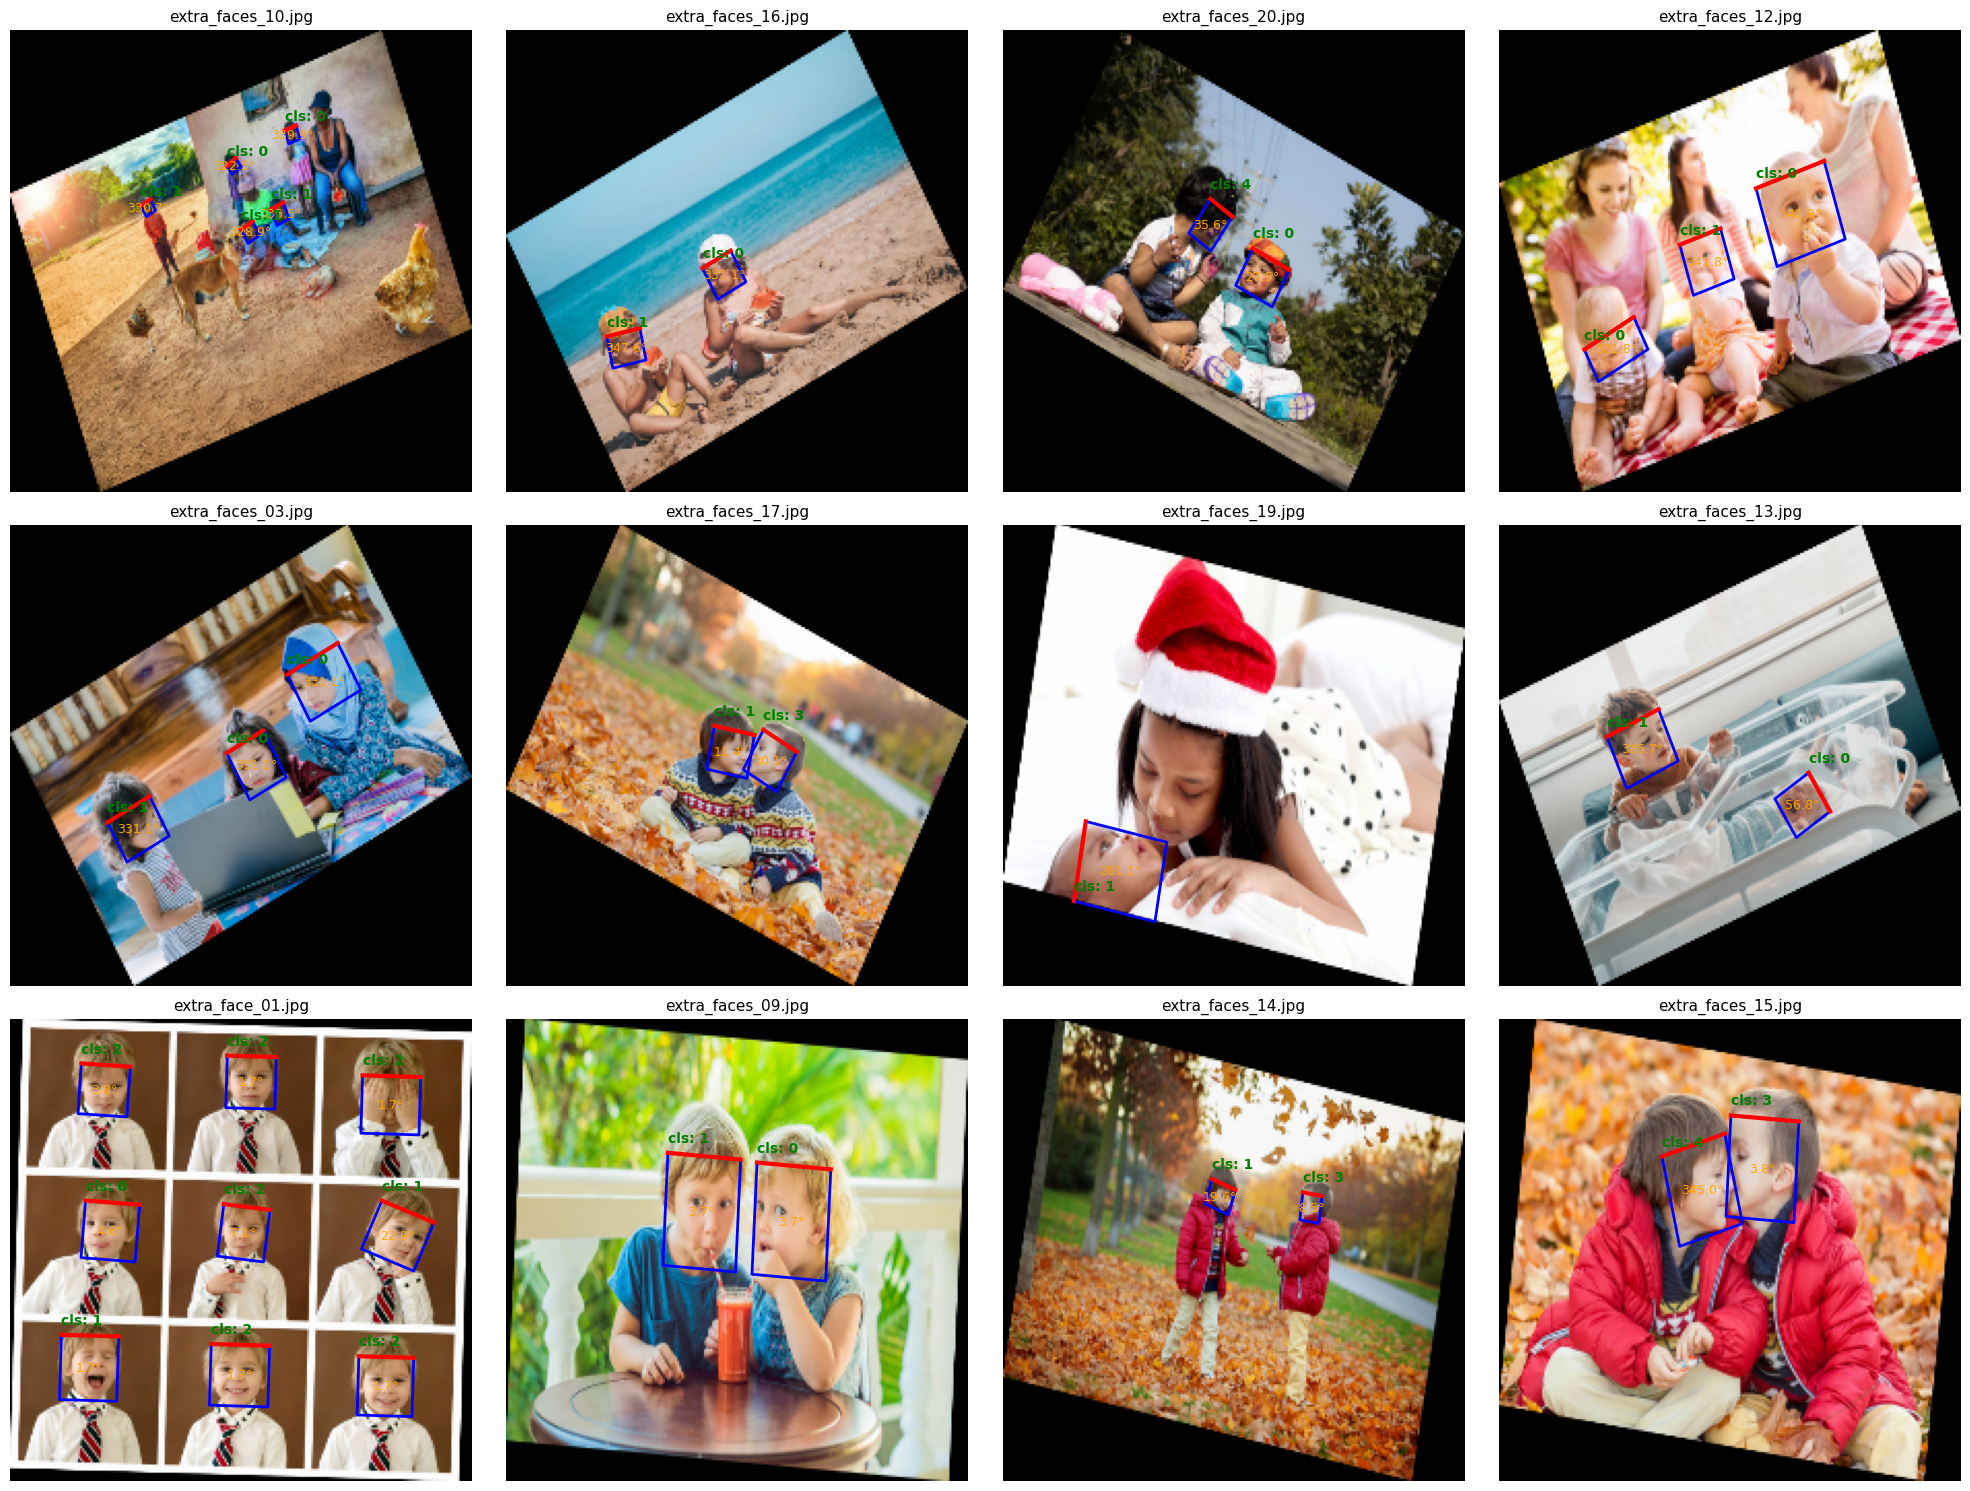

In [9]:
def denormalize_image(img_tensor: torch.Tensor, mean: Tuple[float, float, float] = (0.6427, 0.5918, 0.5526),
                      std: Tuple[float, float, float] = (0.2812, 0.2825, 0.3036)) -> np.ndarray:
    """
    Converts a normalized image tensor (C x H x W) back to a NumPy array (H x W x C) in uint8 format.
    
    Args:
        img_tensor (Tensor): The normalized image tensor.
        mean (tuple): Mean used during normalization (per channel).
        std (tuple): Std used during normalization (per channel).
    
    Returns:
        np.ndarray: Denormalized image in uint8 format.
    """
    img_np = img_tensor.cpu().numpy()  # Convert the tensor to a NumPy array on CPU.
    for c in range(3):  # Iterate through each color channel.
        img_np[c] = img_np[c] * std[c] + mean[c]  # Denormalize the channel.
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)  # Clip and convert to uint8.
    return img_np.transpose(1, 2, 0)  # Convert to H x W x C format.


def draw_obb(ax, box, angle: Optional[float] = None, class_idx: Optional[int] = None,
             top_color: str = 'red', other_color: str = 'blue', linewidth: int = 2):
    """
    Draws an oriented bounding box (OBB) and annotates it with class index and angle.

    Args:
        ax: Matplotlib axis.
        box: List or array of 8 values [x1, y1, ..., x4, y4].
        angle: Rotation angle in radians (optional).
        class_idx: Integer class index (optional).
        top_color: Color of the top edge of the OBB.
        other_color: Color of the other edges of the OBB.
        linewidth: Line width for the OBB.
    """
    pts = np.array(box).reshape(4, 2)  # Reshape the box coordinates to (4, 2).
    pts_closed = np.vstack([pts, pts[0]])  # Close the polygon by adding the first point again.
    ax.plot(pts_closed[:, 0], pts_closed[:, 1], color=other_color, linewidth=linewidth)  # Plot the OBB edges.
    ax.plot([pts[0, 0], pts[1, 0]], [pts[0, 1], pts[1, 1]], color=top_color, linewidth=linewidth + 1)  # Highlight the top edge.

    # Class label near (x1, y1)
    if class_idx is not None:
        ax.text(pts[0, 0], pts[0, 1] - 5, f"cls: {class_idx}", color="green", fontsize=10, weight="bold")  # Add class label.

    # Angle annotation at center of the box
    if angle is not None:
        center = pts.mean(axis=0)  # Calculate the center of the OBB.
        angle_deg = np.degrees(angle)  # Convert angle to degrees.
        ax.text(center[0], center[1], f"{angle_deg:.1f}°", color="orange", fontsize=9, ha="center", va="center")  # Add angle annotation.


def visualize_dataset(dataset, num_images: int = 9):
    """
    Displays 'num_images' samples from the dataset in a grid.
    Shows OBBs with segment highlighting, class_idx, angle, and image filename.
    """
    total = len(dataset)  # Get the total number of samples in the dataset.
    if total == 0:  # Check if the dataset is empty.
        print("Dataset is empty.")
        return

    indices = random.sample(range(total), min(num_images, total))  # Select random indices.
    cols = int(math.ceil(math.sqrt(len(indices))))  # Calculate the number of columns for the grid.
    rows = int(math.ceil(len(indices) / cols))  # Calculate the number of rows for the grid.

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Create the figure and axes.
    axes = np.array(axes).reshape(-1)  # Reshape the axes array to a 1D array.

    for ax in axes[len(indices):]:  # Turn off axes for empty subplots.
        ax.axis("off")

    for i, idx in enumerate(indices):  # Iterate through the selected indices.
        sample = dataset[idx]  # Get the sample.
        image = sample["image"]  # Get the image.
        if torch.is_tensor(image):  # Check if the image is a tensor.
            image_np = denormalize_image(image)  # Denormalize the image.
        else:
            image_np = image.copy()  # Create a copy of the image.

        ax = axes[i]  # Get the current axis.
        ax.imshow(image_np)  # Display the image.
        ax.axis("off")  # Turn off the axis.

        boxes = sample["target"]["boxes"]  # Get the bounding boxes.
        angles = sample["target"]["angles"]  # Get the angles.
        class_idxs = sample["target"]["class_idx"]  # Get the class indices.

        if torch.is_tensor(boxes):  # Check if the boxes are tensors.
            boxes = boxes.cpu().numpy()  # Convert the boxes to NumPy arrays.
        if torch.is_tensor(angles):  # Check if the angles are tensors.
            angles = angles.cpu().numpy()  # Convert the angles to NumPy arrays.
        if torch.is_tensor(class_idxs):  # Check if the class indices are tensors.
            class_idxs = class_idxs.cpu().numpy()  # Convert the class indices to NumPy arrays.

        for j in range(len(boxes)):  # Iterate through the bounding boxes.
            draw_obb(
                ax,
                box=boxes[j],
                angle=angles[j] if j < len(angles) else None,
                class_idx=class_idxs[j] if j < len(class_idxs) else None,
                top_color='red',
                other_color='blue',
                linewidth=2
            )  # Draw the OBB.

        # Add filename title
        base_name = dataset.file_list[idx]  # Get the filename.
        ax.set_title(f"{base_name}.jpg", fontsize=11, color="black")  # Set the title.

    plt.tight_layout()  # Adjust the subplot parameters to give specified padding.
    plt.show()  # Display the plot.


# Ejemplo de uso:
# Supongamos que 'train_dataset' es una instancia de BabyFacesDataset ya creada.
visualize_dataset(train_dataset, num_images=12)



In [10]:
def conv_bn(inp: int, oup: int, stride: int = 1, leaky: float = 0) -> nn.Sequential:
    """
    Creates a convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution. Defaults to 1.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.

    Returns:
        nn.Sequential: A sequential container of the convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # Convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True)  # LeakyReLU activation.
    )


def conv_bn_no_relu(inp: int, oup: int, stride: int) -> nn.Sequential:
    """
    Creates a convolutional layer followed by batch normalization, without ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.

    Returns:
        nn.Sequential: A sequential container of the convolutional and batch normalization layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # Convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
    )


def conv_bn1X1(inp: int, oup: int, stride: int, leaky: float = 0) -> nn.Sequential:
    """
    Creates a 1x1 convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.

    Returns:
        nn.Sequential: A sequential container of the 1x1 convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),  # 1x1 convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True)  # LeakyReLU activation.
    )


def conv_dw(inp: int, oup: int, stride: int, leaky: float = 0.1) -> nn.Sequential:
    """
    Creates a depthwise separable convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.1.

    Returns:
        nn.Sequential: A sequential container of the depthwise and pointwise convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),  # Depthwise convolutional layer.
        nn.BatchNorm2d(inp),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True),  # LeakyReLU activation.

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),  # Pointwise convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True),  # LeakyReLU activation.
    )


class SSH(nn.Module):
    """
    SSH (Single Stage Headless) module, used for feature aggregation.
    """
    def __init__(self, in_channel: int, out_channel: int):
        """
        Initializes the SSH module.

        Args:
            in_channel (int): Number of input channels.
            out_channel (int): Number of output channels.
        """
        super(SSH, self).__init__()
        assert out_channel % 4 == 0  # Ensure output channels are divisible by 4.
        leaky = 0
        if out_channel <= 64:
            leaky = 0.1
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel // 2, stride=1)  # 3x3 convolution.

        self.conv5X5_1 = conv_bn(in_channel, out_channel // 4, stride=1, leaky=leaky)  # 5x5 convolution (part 1).
        self.conv5X5_2 = conv_bn_no_relu(out_channel // 4, out_channel // 4, stride=1)  # 5x5 convolution (part 2).

        self.conv7X7_2 = conv_bn(out_channel // 4, out_channel // 4, stride=1, leaky=leaky)  # 7x7 convolution (part 2).
        self.conv7x7_3 = conv_bn_no_relu(out_channel // 4, out_channel // 4, stride=1)  # 7x7 convolution (part 3).

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the SSH module.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        conv5X5_1 = self.conv5X5_1(input)
        return F.relu(torch.cat([
            self.conv3X3(input),
            self.conv5X5_2(conv5X5_1),
            self.conv7x7_3(self.conv7X7_2(conv5X5_1))
        ], dim=1))


class FPN(nn.Module):
    """
    Feature Pyramid Network (FPN) module for multi-scale feature fusion.
    """
    def __init__(self, in_channels_list: List[int], out_channels: int):
        """
        Initializes the FPN module.

        Args:
            in_channels_list (List[int]): List of input channel numbers for each feature level.
            out_channels (int): Number of output channels.
        """
        super(FPN, self).__init__()
        leaky = 0
        if out_channels <= 64:
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 1.
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 2.
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 3.

        self.merge1 = conv_bn(out_channels, out_channels, leaky=leaky)  # Merge convolution for feature level 1.
        self.merge2 = conv_bn(out_channels, out_channels, leaky=leaky)  # Merge convolution for feature level 2.

    def forward(self, input: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        """
        Forward pass of the FPN module.

        Args:
            input (Dict[str, torch.Tensor]): Dictionary of input feature maps.

        Returns:
            List[torch.Tensor]: List of output feature maps.
        """
        # input is a dictionary with keys 'feat1', 'feat2', 'feat3'.
        input = list(input.values())
        # input[0] is the feature map from the first stage, input[1] from the second stage, and input[2] from the third stage.
        output1 = self.output1(input[0])
        # output2 is the feature map from the second stage, merged with the upsampled feature map from the third stage.
        output2 = self.merge2(self.output2(input[1]) + F.interpolate(self.output3(input[2]), size=input[1].shape[2:], mode="nearest"))
        # output1 is the feature map from the first stage, merged with the upsampled feature map from the second stage.
        output1 = self.merge1(output1 + F.interpolate(output2, size=input[0].shape[2:], mode="nearest"))
        return [output1, output2, self.output3(input[2])]


class MobileNetV1(nn.Module):
    """
    MobileNetV1 backbone network.
    """
    def __init__(self):
        """
        Initializes the MobileNetV1 module.
        """
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.Sequential(
            conv_bn(3, 8, 2, leaky=0.1),  # Stage 1.
            conv_dw(8, 16, 1),
            conv_dw(16, 32, 2),
            conv_dw(32, 32, 1),
            conv_dw(32, 64, 2),
            conv_dw(64, 64, 1),
        )
        self.stage2 = nn.Sequential(
            conv_dw(64, 128, 2),  # Stage 2.
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
        )
        self.stage3 = nn.Sequential(
            conv_dw(128, 256, 2),  # Stage 3.
            conv_dw(256, 256, 1),
        )
        self.avg = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling.
        self.fc = nn.Linear(256, 1000)  # Fully connected layer.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MobileNetV1 module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.fc(self.avg(self.stage3(self.stage2(self.stage1(x)))).view(-1, 256))

In [11]:
def get_default_device() -> torch.device:
    """
    Determines the default device to use for PyTorch computations.

    If a CUDA-enabled GPU is available, it returns "cuda".
    If an MPS-enabled GPU is available, it returns "mps".
    Otherwise, it returns "cpu".

    Returns:
        torch.device: The default PyTorch device.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")  # Use CUDA if available.
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps") # Use MPS if available.
    else:
        return torch.device("cpu")  # Use CPU if no GPU is available.

In [12]:
device = torch.device("cpu") #get_default_device()
device

device(type='cpu')

In [ ]:
class OBBHead(nn.Module):
    """
    Head module for predicting the 8 normalized offsets (Δx, Δy) of the 4 vertices
    of an oriented bounding box (OBB) relative to its anchor.

    The output is constrained to the range [-1, 1] using a tanh activation, so that
    vertex displacements remain within a reasonable distance from the anchor.

    Output shape:
        - Input: (B, C, H, W)
        - Output: (B, N, 8) where N = H × W × num_anchors
    """
    def __init__(self, in_ch: int, num_anchors: int = 3):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, num_anchors * 8, kernel_size=1)

    def forward(self, x):
        # Apply 1x1 convolution, reshape and apply tanh to constrain output to [-1, 1]
        # The output shape is (B, num_anchors * H * W, 8)
        # The 8 values correspond to the 4 vertices of the OBB.
        # The vertices are represented as (Δx1, Δy1, Δx2, Δy2, Δx3, Δy3, Δx4, Δy4)
        # The output is reshaped to (B, N, 8) where N = H × W × num_anchors
        return torch.tanh(self.conv(x).permute(0, 2, 3, 1).contiguous()).view(x.size(0), -1, 8)




class AngleHead(nn.Module):
    """
    Head module for predicting the rotation angle (in radians) of each oriented bounding box (OBB).

    The predicted angle is constrained to the range [0, 2π] using a sigmoid activation followed by scaling.

    Output shape:
        - Input: (B, C, H, W)
        - Output: (B, N, 1) where N = H × W × num_anchors
    """
    def __init__(self, inchannels: int = 64, num_anchors: int = 2):
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * 1, kernel_size=1)

    def forward(self, x):
        # Apply 1x1 convolution, reshape and scale sigmoid output to [0, 2π]
        # The output shape is (B, num_anchors * H * W, 1)
        # The 1 value corresponds to the rotation angle of the OBB.
        # The output is reshaped to (B, N, 1) where N = H × W × num_anchors
        # The angle is represented in radians.
        return (torch.sigmoid(self.conv(x).permute(0, 2, 3, 1).contiguous()) * 2 * math.pi).view(x.size(0), -1, 1)



class ClassHead(nn.Module):
    """
    Head module for class prediction.
    """
    def __init__(self, inchannels: int = 64, num_classes: int = 6, num_anchors: int = 2):
        """
        Initializes the ClassHead module.

        Args:
            inchannels (int): Number of input channels. Defaults to 64.
            num_classes (int): Number of classes to predict. Defaults to 6.
            num_anchors (int): Number of anchors per location. Defaults to 2.
        """
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * num_classes, kernel_size=1)  # 1x1 convolution for class prediction.
        self.num_classes = num_classes  # Store the number of classes.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ClassHead module.

        Args:
            x (torch.Tensor): Input feature map.

        Returns:
            torch.Tensor: Predicted class logits.
        """
        # Apply the convolution and rearrange the tensor dimensions.
        # The output shape is (batch_size, num_anchors * H * W, num_classes).
        # The num_classes values correspond to the class logits for each anchor.
        # The logits are not normalized, so they can be used directly for classification.
        return self.conv(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes)
    
class RetinaBabyFace(nn.Module):
    """
    RetinaBabyFace model integrating backbone, FPN, SSH blocks,
    and multiple prediction heads for oriented bounding box detection, angle estimation, and class prediction.
    """
    def __init__(
        self,
        backbone_name: str = "mobilenetv1",
        out_channel: int = 64,
        pretrained: bool = True,
        freeze_backbone: bool = True
    ):
        """
        Initializes the RetinaBabyFace model.

        Args:
            backbone_name (str): Name of the backbone to use (e.g., "mobilenetv1", "resnet50", "vgg16").
            out_channel (int): Number of output channels for FPN layers.
            pretrained (bool): Whether to load pretrained weights for the backbone.
            freeze_backbone (bool): Whether to freeze backbone weights during training.
        """
        super().__init__()

        # Build backbone and retrieve feature extractor, return layers, and in_channels_list
        self.backbone, return_layers, in_channels_list = self.make_backbone(backbone_name, pretrained)

        # Feature Pyramid Network
        self.fpn = FPN(in_channels_list, out_channel)

        # SSH layers applied on each FPN output
        self.ssh1 = SSH(out_channel, out_channel)
        self.ssh2 = SSH(out_channel, out_channel)
        self.ssh3 = SSH(out_channel, out_channel)

        # Prediction heads: Oriented bounding boxes, rotation angles, and class logits
        self.obb_head = nn.ModuleList([OBBHead(out_channel, num_anchors=9) for _ in range(3)])
        self.angle_head = nn.ModuleList([AngleHead(out_channel, num_anchors=9) for _ in range(3)])
        self.class_head = nn.ModuleList([ClassHead(out_channel, num_anchors=9, num_classes=6) for _ in range(3)])

        # Optionally freeze backbone parameters
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def make_backbone(self, name: str, pretrained: bool) -> tuple[nn.Module, dict, list[int]]:
        """
        Creates and returns a feature extractor from a specified backbone.

        Args:
            name (str): Name of the backbone model.
            pretrained (bool): Whether to use pretrained weights.

        Returns:
            Tuple containing:
                - feature extractor (nn.Module)
                - return_layers (dict): Mapping of layer names to output names
                - in_channels_list (list[int]): Channels for each returned feature map
        """
        if name == "resnet50":
            # Using torchvision's ResNet50 as backbone
            weights = ResNet50_Weights.DEFAULT if pretrained else None
            # Load the ResNet50 model with pretrained weights
            model = resnet50(weights=weights)
            # Extract the feature extractor from the model
            return_layers = {"layer2": "feat1", "layer3": "feat2", "layer4": "feat3"}
            # Define the channels for each returned feature map
            in_channels_list = [512, 1024, 2048]
            # Create the feature extractor
            # The return layers are the last layers of each block in ResNet50
            # The output names are "feat1", "feat2", and "feat3"
            # corresponding to the output of the last conv layer in each block
            feat_ext = create_feature_extractor(model, return_layers)

        elif name == "vgg16":
            # Using torchvision's VGG16 as backbone
            weights = VGG16_Weights.DEFAULT if pretrained else None
            # Load the VGG16 model with pretrained weights
            model = vgg16(weights=weights).features
            # Extract the feature extractor from the model
            # The return layers are the convolutional layers of the model
            # The output names are "feat1", "feat2", and "feat3"
            # corresponding to the output of the last conv layer in each block
            return_layers = {"16": "feat1", "23": "feat2", "30": "feat3"}
            # Define the channels for each returned feature map
            in_channels_list = [256, 512, 512]
            # Create the feature extractor
            feat_ext = create_feature_extractor(model, return_layers)

        elif name == "densenet121":
            # Using torchvision's DenseNet121 as backbone
            weights = DenseNet121_Weights.DEFAULT if pretrained else None
            # Load the DenseNet121 model with pretrained weights
            model = densenet121(weights=weights).features
            # Extract the feature extractor from the model
            # The return layers are the dense blocks of the model
            # The output names are "feat1", "feat2", and "feat3"
            # corresponding to the output of the dense blocks
            # The return_layers dictionary maps the dense block names to output names
            return_layers = {"denseblock2": "feat1", "denseblock3": "feat2", "denseblock4": "feat3"}
            # Define the channels for each returned feature map
            in_channels_list = [512, 1024, 1024]
            feat_ext = create_feature_extractor(model, return_layers)

        elif name == "vit":
            # Using torchvision's Vision Transformer (ViT) as backbone
            weights = ViT_B_16_Weights.DEFAULT if pretrained else None
            # Load the ViT model with pretrained weights
            vit = vit_b_16(weights=weights)
            # Extract the feature extractor from the model
            # The return layers are the transformer encoder layers of the model
            # The output names are "feat1", "feat2", and "feat3"
            # corresponding to the output of the last transformer encoder layers
            return_layers = {
                "encoder.layers.encoder_layer_2": "feat1",
                "encoder.layers.encoder_layer_5": "feat2",
                "encoder.layers.encoder_layer_8": "feat3",
            }
            # Define the channels for each returned feature map
            in_channels_list = [768, 768, 768]
            # Create the feature extractor
            # The return layers are the last layers of each block in ViT
            feat_seq = create_feature_extractor(vit, return_layers)
            # Convert the sequence output to 2D feature maps
            # The output names are "feat1", "feat2", and "feat3"
            feat_ext = ViTFeature2D(feat_seq, patch_size=16)

        else:
            # 
            model = MobileNetV1()
            # Using MobileNetV1 as backbone
            # Extract the feature extractor from the model
            # The return layers are the last layers of each block in MobileNetV1
            return_layers = {"stage1": "feat1", "stage2": "feat2", "stage3": "feat3"}
            in_channels_list = [64, 128, 256]
            feat_ext = create_feature_extractor(model, return_layers)

        return feat_ext, return_layers, in_channels_list

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the RetinaBabyFace model.

        Args:
            x (torch.Tensor): Input image tensor of shape (B, C, H, W).

        Returns:
            Tuple containing:
                - logits (torch.Tensor): Class logits, shape (B, N, num_classes)
                - obbs (torch.Tensor): Predicted OBB vertex displacements, shape (B, N, 8)
                - angs (torch.Tensor): Predicted angles in radians, shape (B, N, 1)
        """
        # Extract features from the backbone
        # The input shape is (B, C, H, W)
        # The output shape is (B, C, H, W) for each feature level
        feats = self.backbone(x)
        # Apply the FPN to the extracted features
        p3, p4, p5 = self.fpn(feats)
        # Apply the SSH blocks to the FPN outputs
        f1, f2, f3 = self.ssh1(p3), self.ssh2(p4), self.ssh3(p5)

        # Concatenate the outputs from the SSH blocks
        logits = torch.cat([h(f) for h, f in zip(self.class_head, (f1, f2, f3))], dim=1)
        # Concatenate the outputs from the OBB and angle heads
        obbs = torch.cat([h(f) for h, f in zip(self.obb_head, (f1, f2, f3))], dim=1)
        # Concatenate the outputs from the angle heads
        angs = torch.cat([h(f) for h, f in zip(self.angle_head, (f1, f2, f3))], dim=1)
        return logits, obbs, angs


class ViTFeature2D(nn.Module):
    """
    Wrapper around a Vision Transformer (ViT) feature extractor that converts sequence outputs
    (flattened tokens) into spatial 2D feature maps, excluding the [CLS] token.
    """
    def __init__(self, seq_extractor: nn.Module, patch_size: int):
        """
        Initializes the ViTFeature2D module.

        Args:
            seq_extractor (nn.Module): ViT-based sequence feature extractor.
            patch_size (int): Size of the patch used in ViT (e.g., 16).
        """
        super().__init__()
        self.seq_extractor = seq_extractor
        self.patch_size = patch_size

    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        """
        Forward pass to convert token sequences into 2D feature maps.

        Args:
            x (torch.Tensor): Input image tensor of shape (B, C, H, W).

        Returns:
            dict[str, torch.Tensor]: Dictionary mapping feature names to 2D feature maps.
        """
        out = self.seq_extractor(x)
        maps = {}
        for name, seq in out.items():
            seq = seq[:, 1:, :]  # Remove [CLS] token
            B, L, C = seq.shape
            H = W = int(L ** 0.5)
            feat2d = seq.permute(0, 2, 1).reshape(B, C, H, W)
            maps[name] = feat2d
        return maps



In [ ]:
seed = set_seed(42)
model_vgg16 = RetinaBabyFace(
    backbone_name   = "vit",
    out_channel     = 256,
    pretrained      = True,
    freeze_backbone = True
).to(device)

In [37]:
summary(model_vgg16, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"], col_width=20, depth=2)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
RetinaBabyFace (RetinaBabyFace)                                        [1, 3, 224, 224]     [1, 5292, 6]         --                   Partial
├─ViTFeature2D (backbone)                                              [1, 3, 224, 224]     [1, 768, 14, 14]     --                   False
│    └─VisionTransformer (seq_extractor)                               [1, 3, 224, 224]     [1, 197, 768]        (78,709,248)         False
├─FPN (fpn)                                                            [1, 768, 14, 14]     [1, 256, 14, 14]     --                   True
│    └─Sequential (output1)                                            [1, 768, 14, 14]     [1, 256, 14, 14]     197,120              True
│    └─Sequential (output2)                                            [1, 768, 14, 14]     [1, 256, 14, 14]     197,120              True
│    └─Sequential

In [38]:
device = "cpu" #get_default_device()
model_vgg16.to(device)
model_vgg16.eval()

dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    persp_logits, obbs, angles = model_vgg16(dummy_input)
    print(persp_logits.shape, obbs.shape, angles.shape)

torch.Size([2, 5292, 6]) torch.Size([2, 5292, 8]) torch.Size([2, 5292, 1])


In [22]:
class AnchorGeneratorOBB:
    """
    AnchorGeneratorOBB generates a grid of oriented anchor boxes (OBBs) across feature map levels
    using dataset-specific statistics such as average box size and aspect ratio.

    Each anchor is represented by 4 corner points (flattened as 8 coordinates) in absolute pixel space,
    assuming axis-aligned rectangles (angle = 0). The anchors can later be refined by predicted deltas.

    This generator supports multiple scales and aspect ratios per location and works with multiple FPN levels.

    Attributes:
        fm_shapes (List[Tuple[int, int]]): Spatial dimensions (height, width) of each feature map.
        strides (List[int]): Stride (downsampling factor) associated with each feature map level.
        scales (List[float]): Absolute anchor sizes derived from base size and scale factors.
        ratios (List[float]): Aspect ratios derived from base ratio and ratio factors.
    """
    def __init__(self,
                 feature_map_shapes: List[Tuple[int, int]],
                 strides: List[int],
                 base_size: float,
                 base_ratio: float,
                 scale_factors: List[float] = [0.75, 1.0, 1.25],
                 ratio_factors: List[float] = [0.85, 1.0, 1.15]):
        """
        Initializes the anchor generator with the given base statistics and FPN configuration.

        Args:
            feature_map_shapes (List[Tuple[int, int]]): (H, W) of each FPN level.
            strides (List[int]): Corresponding strides (e.g., [8, 16, 32]).
            base_size (float): Mean box size (√area) across dataset (e.g., 209.5).
            base_ratio (float): Mean aspect ratio (height / width) across dataset (e.g., 1.18).
            scale_factors (List[float]): Relative size multipliers (default: [0.75, 1.0, 1.25]).
            ratio_factors (List[float]): Aspect ratio multipliers (default: [0.85, 1.0, 1.15]).
        """
        self.fm_shapes = feature_map_shapes
        self.strides = strides
        self.scales = [base_size * s for s in scale_factors]
        self.ratios = [base_ratio * r for r in ratio_factors]

    def generate_anchors(self, device: torch.device) -> torch.Tensor:
        """
        Generates a complete set of anchor boxes for all FPN levels.

        Args:
            device (torch.device): The target device to place the generated anchors on.

        Returns:
            torch.Tensor: Tensor of shape (total_anchors, 8), each row representing
                          an anchor's 4 corner points as [x1, y1, x2, y2, x3, y3, x4, y4].
        """
        anchors_per_image = []

        # Iterate over each feature map shape and stride
        for (fm_shape, stride) in zip(self.fm_shapes, self.strides):
            #   Calculate the grid of centers for the current feature map
            h, w = fm_shape
            #   Create a grid of center points for the anchors
            grid_y, grid_x = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
            #  Convert grid coordinates to pixel space
            centers = np.stack([(grid_x + 0.5) * stride, (grid_y + 0.5) * stride], axis=-1).reshape(-1, 2)

            level_anchors = []
            # Iterate over each scale and aspect ratio
            for scale in self.scales:
                # Iterate over each aspect ratio
                for ratio in self.ratios:
                    # Calculate the width and height of the anchor box
                    area = scale ** 2
                    # Calculate the width and height of the anchor box
                    w_anchor = np.sqrt(area / ratio)
                    h_anchor = w_anchor * ratio
                    # Calculate the half-width and half-height
                    dx, dy = w_anchor / 2, h_anchor / 2

                    # Create axis-aligned rectangle corners centered at origin
                    corners = np.array([
                        [-dx, -dy],
                        [ dx, -dy],
                        [ dx,  dy],
                        [-dx,  dy]
                    ], dtype=np.float32)  # (4, 2)

                    # Translate corners to all grid centers
                    anchors = centers[:, None, :] + corners[None, :, :]  # (N, 4, 2)
                    level_anchors.append(anchors.reshape(-1, 8))  # Flattened OBBs (N, 8)
            # Concatenate all anchors for this feature map level
            all_level_anchors = np.concatenate(level_anchors, axis=0)
            anchors_per_image.append(torch.tensor(all_level_anchors, dtype=torch.float32, device=device))

        return torch.cat(anchors_per_image, dim=0)



def get_feature_map_shapes(model: nn.Module, input_shape: Tuple[int, int, int, int] = (1, 3, 224, 224)) -> List[Tuple[int, int]]:
    """
    Calculates the shape of the feature maps produced by the model's FPN.
    """
    with torch.no_grad():
        dummy_input = torch.zeros(*input_shape).to(next(model.parameters()).device)
        # Extraemos con el backbone (en tu clase es .backbone, no .body)
        feats = model.backbone(dummy_input)  # dict: {'feat1':…, 'feat2':…, 'feat3':…}
        fpn_outs = model.fpn(feats)          # List[Tensor]
        return [(f.shape[2], f.shape[3]) for f in fpn_outs]


In [15]:
def xyxyxyxy2xywhr(obb: torch.Tensor, angle: torch.Tensor, image_size: Tuple[int, int]) -> torch.Tensor:
    """
    Converts an oriented bounding box (OBB) from 8-point corner format (xyxyxyxy) and a given rotation angle
    to the (x_center, y_center, width, height, rotation) format (xywhr) in **absolute pixel coordinates**.

    This function supports both normalized and unnormalized input coordinates. If the coordinates appear
    to be normalized (i.e., values in [0, 1]), they are automatically scaled using the provided image size.

    Args:
        obb (torch.Tensor): Tensor of shape (N, 8) or (8,) containing 4 corner points of the OBB in the format:
                            [x1, y1, x2, y2, x3, y3, x4, y4].
        angle (torch.Tensor): Tensor of shape (N,) or scalar with angles in radians, one per OBB.
        image_size (Tuple[int, int]): Size of the image as (width, height).

    Returns:
        torch.Tensor: Tensor of shape (N, 5) in the format (x_center, y_center, width, height, angle), 
                      all in pixel units.
    """
    if obb.ndim == 1:
        obb = obb.unsqueeze(0)
    N = obb.shape[0]
    device = obb.device
    W, H = image_size

    # Automatically scale if coordinates are normalized
    if obb.max() <= 1.0:
        obb_pix = obb * torch.tensor([W, H] * 4, device=device).float()
    else:
        obb_pix = obb

    obb_pix = obb_pix.view(N, 4, 2)                        # Convert flat to (N, 4, 2)
    center = obb_pix.mean(dim=1)                          # Compute box center from corner average

    p0, p1, p2 = obb_pix[:, 0], obb_pix[:, 1], obb_pix[:, 2]
    width = (p1 - p0).norm(dim=1)                         # Width: distance between point 0 and 1
    height = (p2 - p1).norm(dim=1)                        # Height: distance between point 1 and 2

    angle_tensor = angle.to(device).float().view(-1, 1)   # Ensure shape (N, 1)

    return torch.cat([center, width.unsqueeze(1), height.unsqueeze(1), angle_tensor], dim=1)



def get_covariance_matrix(boxes: torch.Tensor):
    """
    Computes the covariance components (a, b, c) of oriented bounding boxes (OBBs) in xywhr format.

    This representation is used for probabilistic IoU computation between Gaussian-modeled OBBs.
    The (x, y) center is ignored, and only width, height, and rotation are used.

    Args:
        boxes (torch.Tensor): Tensor of shape (N, 5) in (x, y, w, h, θ) format, where θ is in radians.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Covariance components a, b, c for each box.
    """
    # Convert width/height to variance form: (w²/12, h²/12)
    gbbs = torch.cat((boxes[:, 2:4].pow(2) / 12, boxes[:, 4:]), dim=-1)
    a, b, c = gbbs.split(1, dim=-1)  # a: var_x, b: var_y, c: rotation

    # Compute cos and sin of the rotation angle
    cos, sin = c.cos(), c.sin()
    cos2, sin2 = cos.pow(2), sin.pow(2)

    # Compute rotated covariance components
    return a * cos2 + b * sin2, a * sin2 + b * cos2, (a - b) * cos * sin

def compute_obb_iou_matrix_xywhr(anchors_xywhr: torch.Tensor, gt_xywhr: torch.Tensor) -> torch.Tensor:
    """
    Computes the pairwise probabilistic IoU (pIoU) between two sets of oriented bounding boxes in xywhr format.

    This implementation is based on the probabilistic IoU from:
    "Learning Probabilistic Oriented Object Detection via Gaussian Distribution" (CVPR 2021).
    
    Args:
        anchors_xywhr (torch.Tensor): Tensor of shape (M, 5) with predicted OBBs in (x, y, w, h, θ) format.
        gt_xywhr (torch.Tensor): Tensor of shape (N, 5) with ground truth OBBs in (x, y, w, h, θ) format.

    Returns:
        torch.Tensor: IoU similarity matrix of shape (N, M) where entry (i, j) is the similarity between
                      gt i and anchor j.
    """
    def batch_probiou(obb1: torch.Tensor, obb2: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
        """
        Vectorized computation of probabilistic IoU between two sets of OBBs.

        Args:
            obb1 (torch.Tensor): Tensor of shape (N, 5) for GT boxes.
            obb2 (torch.Tensor): Tensor of shape (M, 5) for predicted boxes.
            eps (float): Small value for numerical stability.

        Returns:
            torch.Tensor: Tensor of shape (N, M) with probabilistic IoU values.
        """
        # Ensure input tensors are on the same device
        obb1 = torch.from_numpy(obb1) if isinstance(obb1, np.ndarray) else obb1
        obb2 = torch.from_numpy(obb2) if isinstance(obb2, np.ndarray) else obb2

        # Extract x, y, width, height, and angle from the OBBs
        x1, y1 = obb1[..., :2].split(1, dim=-1)
        x2, y2 = (x.squeeze(-1)[None] for x in obb2[..., :2].split(1, dim=-1))
        
        # Compute covariance components for both sets of OBBs
        a1, b1, c1 = get_covariance_matrix(obb1)
        a2, b2, c2 = (x.squeeze(-1)[None] for x in get_covariance_matrix(obb2))

        # Mahalanobis-like distance between centers
        t1 = ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / \
             ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps) * 0.25

        # Cross-correlation term
        t2 = ((c1 + c2) * (x2 - x1) * (y1 - y2)) / \
             ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps) * 0.5

        # Log-determinant divergence between covariances
        det1 = (a1 * b1 - c1.pow(2)).clamp(min=0)
        det2 = (a2 * b2 - c2.pow(2)).clamp(min=0)
        # Compute the log-determinant divergence
        # Note: det1 and det2 are positive, so we can safely take the square root
        # and add eps for numerical stability
        t3 = ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2)) / \
             (4 * (det1 * det2).sqrt() + eps)
        t3 = (t3 + eps).log() * 0.5

        # Bhattacharyya distance (bounded)
        bd = (t1 + t2 + t3).clamp(min=eps, max=100.0)

        # Convert to similarity
        hd = (1.0 - (-bd).exp() + eps).sqrt()
        return 1 - hd

    return batch_probiou(anchors_xywhr, gt_xywhr)


def match_anchors_to_targets(
    anchors_xywhr: torch.Tensor,   # (N, 5) — Precomputed anchor boxes in (x, y, w, h, θ)
    gt_boxes_xy: torch.Tensor,     # (M, 8) — Ground truth OBBs in 4-point (x1y1...x4y4) format
    gt_angles: torch.Tensor,       # (M,)   — Rotation angles in radians
    image_size: Tuple[int, int],   # (W, H)
    iou_thr: float = 0.5           # IoU threshold for positive match
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Matches precomputed anchors to ground truth oriented bounding boxes using pIoU.

    Converts the ground truth boxes from 8-point + angle format to xywhr,
    computes pairwise pIoU, and assigns the best matching GT to each anchor.

    Args:
        anchors_xywhr (torch.Tensor): Anchor boxes, shape (N, 5), format (x, y, w, h, θ).
        gt_boxes_xy (torch.Tensor): Ground truth boxes in xyxyxyxy format, shape (M, 8).
        gt_angles (torch.Tensor): Rotation angles for GT boxes in radians, shape (M,).
        image_size (Tuple[int, int]): Size of the image (width, height).
        iou_thr (float, optional): IoU threshold to determine positive matches. Default is 0.5.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: 
            - A boolean tensor of shape (N,) indicating which anchors are matched (positive).
            - A tensor of shape (N,) with the index of the best GT box for each anchor.
    """
    W, H = image_size
    gt_xywhr = xyxyxyxy2xywhr(gt_boxes_xy, gt_angles, (W, H))

    # Compute pairwise pIoU between anchors and GT boxes
    iou_matrix = compute_obb_iou_matrix_xywhr(anchors_xywhr, gt_xywhr)
    iou, best_gt = iou_matrix.max(dim=1)  # Best match for each anchor

    return iou > iou_thr, best_gt



def probiou(
    obb1: torch.Tensor, 
    obb2: torch.Tensor, 
    CIoU: bool = False, 
    eps: float = 1e-7
) -> torch.Tensor:
    """
    Computes the probabilistic IoU (pIoU) between oriented bounding boxes.

    Optionally includes the Complete IoU (CIoU) term, penalizing aspect ratio mismatches,
    inspired by standard CIoU in axis-aligned box regression.

    Args:
        obb1 (torch.Tensor): Ground truth OBBs of shape (N, 5), format (x, y, w, h, θ).
        obb2 (torch.Tensor): Predicted OBBs of shape (N, 5), format (x, y, w, h, θ).
        CIoU (bool, optional): If True, adds the CIoU penalty term. Default is False.
        eps (float, optional): Small constant for numerical stability. Default is 1e-7.

    Returns:
        torch.Tensor: Probabilistic IoU values for each pair, shape (N,).
    
    References:
        - https://arxiv.org/pdf/2106.06072v1.pdf (pIoU for Gaussian Boxes)
        - https://arxiv.org/abs/1911.08287 (CIoU term inspiration)
    """
    # Ensure input tensors are on the same device
    x1, y1 = obb1[..., :2].split(1, dim=-1)
    x2, y2 = obb2[..., :2].split(1, dim=-1)

    # Compute covariance components for both sets of OBBs
    a1, b1, c1 = get_covariance_matrix(obb1)
    a2, b2, c2 = get_covariance_matrix(obb2)

    # Mahalanobis-like center distance
    t1 = ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / \
         ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps) * 0.25

    # Cross-correlation term
    t2 = ((c1 + c2) * (x2 - x1) * (y1 - y2)) / \
         ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps) * 0.5

    # Covariance divergence
    det1 = (a1 * b1 - c1.pow(2)).clamp(min=0)
    det2 = (a2 * b2 - c2.pow(2)).clamp(min=0)
    t3 = ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2)) / (4 * (det1 * det2).sqrt() + eps)
    t3 = (t3 + eps).log() * 0.5

    # Bhattacharyya distance
    bd = (t1 + t2 + t3).clamp(min=eps, max=100.0)
    hd = (1.0 - (-bd).exp() + eps).sqrt()
    iou = 1 - hd

    # Optional CIoU penalty
    if CIoU:
        # Compute aspect ratio penalty
        # Convert width/height to variance form: (w²/12, h²/12)
        
        w1, h1 = obb1[..., 2:4].split(1, dim=-1)
        w2, h2 = obb2[..., 2:4].split(1, dim=-1)
        v = (4 / math.pi**2) * ((w2 / h2).atan() - (w1 / h1).atan()).pow(2)
        with torch.no_grad():
            # Compute the aspect ratio penalty
            alpha = v / (v - iou + (1 + eps))
        return iou - alpha * v  # CIoU

    return iou


def decode_vertices(
    deltas: torch.Tensor,          # (N, 8) — Predicted normalized offsets from anchor vertices
    anchors: torch.Tensor,         # (N, 8) — Anchor box vertices in pixel coordinates
    image_size: Tuple[int, int],   # (W, H)
    use_diag: bool = True          # Whether to scale offsets by the anchor's diagonal
) -> torch.Tensor:
    """
    Decodes predicted OBB vertex offsets back to absolute vertex coordinates.

    The deltas are learned displacements for each of the 4 vertices of an OBB, normalized
    to [-1, 1] via a tanh activation. This function rescales and shifts these deltas
    with respect to the given anchor boxes.

    Args:
        deltas (torch.Tensor): Offset predictions of shape (N, 8), in the range [-1, 1].
        anchors (torch.Tensor): Anchor box vertices of shape (N, 8), in pixel coordinates.
        image_size (Tuple[int, int]): (width, height) of the image to clamp the results.
        use_diag (bool, optional): 
            If True, offsets are scaled by the average diagonal of the anchor box
            (i.e., roughly its "natural" size). If False, the offsets are interpreted
            as pixel values directly. Default is True.

    Returns:
        torch.Tensor: Decoded absolute vertex positions of shape (N, 8), clamped to image bounds.
    """
    W, H = image_size

    if use_diag:
        # Use average diagonal length as a scale factor (per box)
        diag = anchors.view(-1, 4, 2).std(dim=1).mean(dim=1, keepdim=True)  # (N, 1)
        verts = anchors + deltas * diag  # Displace each vertex up to ±diag pixels
    else:
        # Direct displacement in pixel space
        verts = anchors + deltas  # Displace only ±1 px per dimension

    # Clamp decoded vertices to valid image bounds
    clamp_vec = verts.new_tensor([W, H] * 4)   # (8,)
    verts = torch.clamp_min(verts, 0.0)        # Lower bound: 0
    verts = torch.minimum(verts, clamp_vec)    # Upper bound: image size

    return verts



In [16]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for multi-class classification with imbalance handling.

    References:
        - https://arxiv.org/abs/1708.02002
    """
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        """
        Args:
            alpha (float): Balancing factor for the rare class. Default is 0.25.
            gamma (float): Focusing parameter to down-weight easy examples. Default is 2.0.
        """
        super().__init__()
        self.alpha, self.gamma = alpha, gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes focal loss between predicted logits and target class indices.

        Args:
            logits (torch.Tensor): Class logits of shape (B, N, C) or (N, C).
            targets (torch.Tensor): Integer class labels of shape (B, N) or (N,).

        Returns:
            torch.Tensor: Scalar loss value.
        """
        if logits.dim() == 2:  # Support batched or unbatched input
            logits = logits.unsqueeze(0)
            targets = targets.unsqueeze(0)

        # Ensure logits are in the correct shape
        B, N, C = logits.shape
        # Ensure targets are in the correct shape
        onehot = F.one_hot(targets.clamp_max(C - 1), C).float()  # (B, N, C)

        # Compute the focal loss
        loss = sigmoid_focal_loss(
            logits.view(-1, C), # Flatten logits to (B*N, C)
            onehot.view(-1, C), # Flatten onehot to (B*N, C)
            alpha=self.alpha, # Balancing factor
            gamma=self.gamma, # Focusing parameter
            reduction="none"
        )
        return loss.mean()


class RotationLoss(nn.Module):
    """
    Module for calculating the rotation loss between predicted and ground truth angles.
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred_angles: torch.Tensor, gt_angles: torch.Tensor, valid_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Calculates the rotation loss.

        The loss function is defined as:
        L_rot = 1 - cos(pred_angle - gt_angle)

        This loss penalizes the difference between predicted and ground truth angles,
        with a higher loss for larger differences.

        Args:
            pred_angles (torch.Tensor): Predicted angles tensor of shape (B, N, 1).
            gt_angles (torch.Tensor): Ground truth angles tensor of shape (B, N, 1).
            valid_mask (torch.Tensor, optional): Valid mask tensor of shape (B, N) to exclude certain predictions from loss calculation.

        Returns:
            torch.Tensor: The mean rotation loss.
        """
        # Both tensors are of shape (B, N, 1)
        diff = pred_angles - gt_angles   # (…,1)
        loss = 1 - torch.cos(diff)
        if valid_mask is not None:
            loss = loss[valid_mask]  # Apply valid mask to exclude certain predictions from loss.
        return loss.mean()  # Return the mean rotation loss.


class OBBLoss(nn.Module):
    """
    Computes loss between predicted and ground-truth Oriented Bounding Boxes (OBBs)
    using probabilistic IoU as a similarity metric.

    Note:
        - Boxes are expected in vertex format (xyxyxyxy) and angles in radians.
        - Internally converts boxes to xywhr format.
    """
    def __init__(self):
        super().__init__()

    def forward(
        self,
        pred_obbs: torch.Tensor,         # (B, N, 8)
        gt_obbs: torch.Tensor,           # (B, N, 8)
        angles_pred: torch.Tensor,       # (B, N, 1)
        gt_angles: torch.Tensor,         # (B, N, 1)
        image_size: List[Tuple[int, int]],
        valid_mask: torch.Tensor = None  # (B, N) boolean mask for valid anchors
    ) -> torch.Tensor:
        """
        Args:
            pred_obbs (torch.Tensor): Predicted vertices, shape (B, N, 8).
            gt_obbs (torch.Tensor): Ground truth vertices, shape (B, N, 8).
            angles_pred (torch.Tensor): Predicted angles in radians, shape (B, N, 1).
            gt_angles (torch.Tensor): Ground truth angles in radians, shape (B, N, 1).
            image_size (List[Tuple[int, int]]): List of image sizes (W, H) for each sample in batch.
            valid_mask (torch.Tensor, optional): Boolean mask for valid anchors. Defaults to None.

        Returns:
            torch.Tensor: Scalar loss value.
        """
        B, N, _ = pred_obbs.shape
        losses = []

        for b in range(B):
            W, H = image_size[b]

            # Convert both boxes to xywhr format
            pred_xywhr = xyxyxyxy2xywhr(pred_obbs[b], angles_pred[b].squeeze(-1), (W, H))
            gt_xywhr   = xyxyxyxy2xywhr(gt_obbs[b], gt_angles[b].squeeze(-1), (W, H))

            # Compute the probabilistic IoU
            # Note: the function is vectorized and computes all pairwise IoUs
            # between the predicted and ground truth boxes
            if valid_mask is not None:
                # Apply the valid mask to filter out invalid predictions
                mask = valid_mask[b]
                # Ensure the mask is applied to both pred and gt boxes
                pred_xywhr = pred_xywhr[mask]
                gt_xywhr = gt_xywhr[mask]

            # If there are no valid predictions, skip this batch
            if pred_xywhr.numel() == 0:
                continue
            # Compute the probabilistic IoU
            # Note: probiou returns a matrix of shape (N, M) where N is the number of gt boxes
            # and M is the number of pred boxes
            # We take the mean IoU across all gt boxes for this batch
            # and all pred boxes
            iou = probiou(pred_xywhr, gt_xywhr)
            losses.append((1.0 - iou).mean())

        if len(losses) == 0:
            return torch.tensor(0.0, requires_grad=True, device=pred_obbs.device)

        return torch.stack(losses).mean()


class MultiTaskLoss(nn.Module):
    """
    Combines classification, OBB regression, and angle regression into a single multitask loss.

    Total Loss:
        L_total = lambda_cls * L_focal + lambda_obb * L_iou + lambda_rot * L_angle

    Args:
        lambda_cls (float): Weight for classification loss.
        lambda_obb (float): Weight for OBB regression loss.
        lambda_rot (float): Weight for rotation angle loss.
    """
    def __init__(self, lambda_cls: float = 1.0, lambda_obb: float = 1.0, lambda_rot: float = 0.5):
        super().__init__()
        self.focal_loss  = FocalLoss()
        self.obb_loss = OBBLoss()
        self.rot_loss    = RotationLoss()
        self.lambda_cls, self.lambda_obb, self.lambda_rot = lambda_cls, lambda_obb, lambda_rot

    def forward(
        self,
        preds: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
        targets: Dict[str, torch.Tensor],
        anchors_xy: torch.Tensor,
        anchors_xywhr: torch.Tensor,
        image_sizes: List[Tuple[int, int]]
    ):
        """
        Args:
            preds (Tuple): Tuple of model outputs: (logits, deltas, angles)
            targets (Dict): Dictionary with GT boxes, angles and class indices
            anchors_xy (torch.Tensor): Anchor vertices (B, N, 8)
            anchors_xywhr (torch.Tensor): Anchor OBBs in xywhr format (N, 5)
            image_sizes (List[Tuple[int,int]]): Sizes of each image in the batch

        Returns:
            Tuple[torch.Tensor, float, float, float]: 
                - Total loss
                - Classification loss (float)
                - OBB loss (float)
                - Angle regression loss (float)
        """
        logits, deltas, pred_angles = preds  # (B,N,C), (B,N,8), (B,N,1)
        B, N, _ = logits.shape

        loss_cls = loss_obb = loss_rot = 0.0
        valid_batches = 0

        for b in range(B):
            # 1) Anchor-to-GT assignment
            pos_mask, best_gt = match_anchors_to_targets(
                anchors_xywhr, targets["boxes"][b], targets["angle"][b].squeeze(-1), image_sizes[b]
            )

            # 2) Classification loss (all anchors)
            tgt_cls = torch.full((N,), 5, dtype=torch.long, device=logits.device)
            tgt_cls[pos_mask] = targets["class_idx"][b][best_gt[pos_mask]]
            loss_cls += self.focal_loss(logits[b], tgt_cls)

            # 3) OBB + Angle loss (only positive anchors)
            if pos_mask.any():
                # Only consider positive anchors
                valid_batches += 1
                # Extract the positive anchors
                idx = best_gt[pos_mask]

                # Compute the OBB loss
                # Note: pred_xy is in xywhr format
                # Convert deltas to absolute vertex coordinates
                # Note: deltas are in normalized coordinates
                # Decode the deltas to get the predicted vertices
                # Note: anchors_xy are in pixel coordinates
                pred_xy = decode_vertices(
                    deltas[b][pos_mask], anchors_xy[b][pos_mask], image_sizes[b]
                )

                loss_obb += self.obb_loss(
                    pred_xy.unsqueeze(0),
                    targets["boxes"][b][idx].unsqueeze(0),
                    pred_angles[b][pos_mask].unsqueeze(0),
                    targets["angle"][b][idx].unsqueeze(0),
                    [image_sizes[b]],
                    valid_mask=torch.ones(1, idx.numel(), dtype=torch.bool, device=logits.device)
                )

                loss_rot += self.rot_loss(
                    pred_angles[b][pos_mask],
                    targets["angle"][b][idx]
                )

        # Final aggregation
        loss_cls /= B
        if valid_batches == 0:
            # No valid batches, return only classification loss
            total = self.lambda_cls * loss_cls
            return total, loss_cls.item(), 0.0, 0.0

        loss_obb /= valid_batches
        loss_rot /= valid_batches
        total = self.lambda_cls * loss_cls + self.lambda_obb * loss_obb + self.lambda_rot * loss_rot
        return total, loss_cls.item(), loss_obb.item(), loss_rot.item()

In [17]:
def xywhr2xyxyxyxy(xywhr: torch.Tensor) -> np.ndarray:
    """
    Converts a batch of boxes from xywhr format to 4 corner coordinates (N, 4, 2).
    The xywhr format is defined as (cx, cy, w, h, angle), where:
        - cx, cy: center coordinates
        - w, h: width and height
        - angle: rotation angle in radians
    The output format is a list of 4 corner points for each box in the order:
        [top-left, top-right, bottom-right, bottom-left].
    Args:
        xywhr (torch.Tensor): Tensor of shape (N, 5) in xywhr format.
    Returns:
        np.ndarray: Array of shape (N, 4, 2) with corner coordinates.
    """
    # 
    cx, cy, w, h, angle = xywhr.T
    dx, dy = w / 2, h / 2

    # Initial corners before rotation
    corners = torch.stack([
        torch.stack([-dx, -dy], dim=1),
        torch.stack([ dx, -dy], dim=1),
        torch.stack([ dx,  dy], dim=1),
        torch.stack([-dx,  dy], dim=1),
    ], dim=1)

    # Rotation matrix
    cos_a, sin_a = torch.cos(angle), torch.sin(angle)
    # Construct the rotation matrix
    rot_matrix = torch.stack([
        torch.stack([cos_a, -sin_a], dim=1),
        torch.stack([sin_a,  cos_a], dim=1)
    ], dim=2)
    
    # Rotate the corners
    # corners: (N, 4, 2)
    # rot_matrix: (N, 2, 2)
    # Perform batch matrix multiplication
    # Note: corners are in shape (N, 4, 2) and rot_matrix is in shape (N, 2, 2)
    # The result is (N, 4, 2) after rotation
    # and translation
    rotated = torch.bmm(corners, rot_matrix)
    centers = torch.stack([cx, cy], dim=1)[:, None, :]
    return (rotated + centers).detach().cpu().numpy()

def show_obbs_on_image(image_tensor: torch.Tensor,
                       pred_xywhr: torch.Tensor,
                       gt_xywhr: torch.Tensor,
                       image_size: Tuple[int, int]):
    """
    Draws predicted and ground truth OBBs over the original image.

    Args:
        image_tensor (Tensor): Normalized image tensor (3, H, W).
        pred_xywhr (Tensor): Predicted OBBs (N, 5) in [cx, cy, w, h, angle] format.
        gt_xywhr (Tensor): Ground truth OBBs (N, 5) in [cx, cy, w, h, angle] format.
        image_size (Tuple[int, int]): (W, H) dimensions of the image.
        
    """
    
    # Convert image tensor to numpy array
    image_np = denormalize_image(image_tensor)
    # Convert to 4 corner format
    pred_corners = xywhr2xyxyxyxy(pred_xywhr)
    gt_corners = xywhr2xyxyxyxy(gt_xywhr)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_np)
    ax.set_title("OBB Prediction vs Ground Truth")
    ax.axis("off")

    # Draw GT
    for i in range(len(gt_corners)):
        # Draw the GT corners
        # Note: gt_corners[i] is in shape (4, 2)
        # and gt_xywhr[i] is in shape (5,)
        ax.add_patch(MplPolygon(gt_corners[i], closed=True, fill=False, edgecolor='blue', linewidth=1.5, label='GT' if i == 0 else None))
        ax.scatter(*gt_xywhr[i, :2].detach().cpu().numpy(), color='blue', s=10)

    # Draw predictions
    for i in range(len(pred_corners)):
        # Draw the predicted corners
        # Note: pred_corners[i] is in shape (4, 2)
        # and pred_xywhr[i] is in shape (5,)
        ax.add_patch(MplPolygon(pred_corners[i], closed=True, fill=False, edgecolor='red', linestyle='--', linewidth=1.5, label='Pred' if i == 0 else None))
        ax.scatter(*pred_xywhr[i, :2].detach().cpu().numpy(), color='red', marker='x', s=10)

    # Only show unique legend labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower right')

    plt.tight_layout()
    plt.show()


In [18]:
class EarlyStopping:
    """
    EarlyStopping can be used to monitor the validation loss during training and stop the training process early
    if the validation loss does not improve after a certain number of epochs. It can handle both KFold and 
    non-KFold cases.
    """

    def __init__(
        self,
        patience: int = 7,
        verbose: bool = False,
        delta: float = 0,
        path: str = "checkpoint.pt",
        use_kfold: bool = False,
        trace_func=print,
    ):
        """
        Initializes the EarlyStopping object with the given parameters.

        Args:
            patience: How long to wait after last time validation loss improved.
            verbose: If True, prints a message for each validation loss improvement.
            delta: Minimum change in the monitored quantity to qualify as an improvement.
            path: Path for the checkpoint to be saved to.
            use_kfold: If True, saves the model with the lowest loss metric for each fold.
            trace_func: trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.use_kfold = use_kfold
        self.trace_func = trace_func
        self.fold = None
        self.filename = None

    def __call__(self, val_loss: float, model: nn.Module, fold: int = None):
        """
        This method is called during the training process to monitor the validation loss and decide whether to stop
        the training process early or not.

        Args:
            val_loss: Validation loss of the model at the current epoch.
            model: The PyTorch model being trained.
            fold: The current fold of the KFold cross-validation. Required if use_kfold is True.
        """
        if self.use_kfold:
            assert fold is not None, "Fold must be provided when use_kfold is True"

            # If it's a new fold, resets the early stopping object and sets the filename to save the model
            if fold != self.fold:
                self.fold = fold
                self.counter = 0
                self.best_score = None
                self.early_stop = False
                self.val_loss_min = np.Inf
                self.filename = self.path.replace(".pt", f"_fold_{fold}.pt")

        # Calculating the score by negating the validation loss
        score = -val_loss

        # If the best score is None, sets it to the current score and saves the checkpoint
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        # If the score is less than the best score plus delta, increments the counter
        # and checks if the patience has been reached
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True

        # If the score is better than the best score plus delta, saves the checkpoint and resets the counter
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: nn.Module):
        """
        Saves the model when validation loss decreases.

        Args:
            val_loss: The current validation loss.
            model: The PyTorch model being trained.
        """
        # If verbose mode is on, print a message about the validation loss decreasing and saving the model
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ..."
            )

        # Save the state of the model to the appropriate filename based on whether KFold is used or not
        if self.use_kfold:
            torch.save(model.state_dict(), self.filename)
        else:
            torch.save(model.state_dict(), self.path)

        # Update the minimum validation loss seen so far to the current validation loss
        self.val_loss_min = val_loss

In [19]:
def visualize_predictions(images, pred_obbs, pred_angles, gt_obbs, gt_angles, anchors, image_sizes):
    """
    Optionally visualizes the predicted vs ground truth oriented bounding boxes (OBBs) 
    for the second image in the batch. Intended for debugging or qualitative inspection.

    Args:
        images (Tensor): Batch of input images (B, C, H, W).
        pred_obbs (Tensor): Predicted offset vertices, shape (B, N, 8).
        pred_angles (Tensor): Predicted angles, shape (B, N, 1).
        gt_obbs (Tensor): Ground truth OBBs, shape (B, N, 8).
        gt_angles (Tensor): Ground truth angles, shape (B, N, 1).
        anchors (Tensor): Anchor vertices in pixel space, shape (B, N, 8).
        image_sizes (List[Tuple[int, int]]): List of image sizes in (W, H) format.
    """
    W, H = image_sizes[0]
    
    pred_xy = decode_vertices(pred_obbs[0], anchors[0], (W, H))
    pred_xywhr = xyxyxyxy2xywhr(pred_xy, pred_angles[0].squeeze(-1), (W, H))
    gt_xywhr = xyxyxyxy2xywhr(gt_obbs[0], gt_angles[1], (W, H))

    print("Pred:", pred_xywhr[0].tolist())
    print("GT:", gt_xywhr[0].tolist())

    show_obbs_on_image(images[0], pred_xywhr[0].unsqueeze(0), gt_xywhr[0].unsqueeze(0), (W, H))


In [20]:
def create_optimizer(which_optimizer: str,
                     model: nn.Module,
                     learning_rate: float,
                     weight_decay: float) -> torch.optim.Optimizer:
    """
    Creates an optimizer for the model.

    Args:
        which_optimizer (str): The optimizer to use ('ADAM' or 'SGD').
        model (nn.Module): The model to optimize.
        learning_rate (float): The learning rate.
        weight_decay (float): The weight decay.

    Returns:
        torch.optim.Optimizer: The optimizer.

    Raises:
        ValueError: If the optimizer is not 'ADAM' or 'SGD'.
    """
    if which_optimizer == "ADAM":
        return Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
    elif which_optimizer == "SGD":
        return SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError("The optimizer must be 'ADAM' or 'SGD'.")


def create_scheduler(which_scheduler: Optional[str],
                     optimizer: torch.optim.Optimizer,
                     learning_rate: float,
                     epochs: int,
                     train_dataloader: DataLoader) -> Optional[lr_scheduler._LRScheduler]:
    """
    Creates a learning rate scheduler.

    Args:
        which_scheduler (Optional[str]): The scheduler to use ('ReduceLR', 'OneCycle', 'Cosine', or None).
        optimizer (torch.optim.Optimizer): The optimizer.
        learning_rate (float): The initial learning rate.
        epochs (int): The number of epochs.
        train_dataloader (DataLoader): The training data loader.

    Returns:
        Optional[lr_scheduler._LRScheduler]: The learning rate scheduler, or None if no scheduler is used.

    Raises:
        ValueError: If the scheduler is not 'ReduceLR', 'OneCycle', or 'Cosine'.
    """
    if which_scheduler == "ReduceLR":
        return lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=5, min_lr=1e-5)
    elif which_scheduler == "OneCycle":
        return lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate * 10, epochs=epochs,
                                       steps_per_epoch=len(train_dataloader))
    elif which_scheduler == "Cosine":
        return lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    elif which_scheduler is None:
        return None
    else:
        raise ValueError("The scheduler for learning rate must be either 'ReduceLR', 'OneCycle', or 'Cosine'")

def build_multitask_targets(batch_targets: Dict[str, torch.Tensor],
                            device: torch.device) -> Dict[str, torch.Tensor]:
    """
    Prepares and formats the target dictionary for the multitask model by moving tensors to the desired device
    and adjusting shapes as needed.

    Args:
        batch_targets (Dict[str, torch.Tensor]): Dictionary containing:
            - "boxes"      : (B, N, 8)  -> Oriented bounding boxes (vertices).
            - "angles"     : (B, N)     -> Rotation angles in radians.
            - "class_idx"  : (B, N)     -> Class labels per box.
            - "valid_mask" : (B, N)     -> Mask indicating valid boxes.
        device (torch.device): Device to move all tensors to (e.g., CUDA or CPU).

    Returns:
        Dict[str, torch.Tensor]: Dictionary with preprocessed targets for loss computation:
            - "class_idx"  : (B, N)
            - "boxes"      : (B, N, 8)
            - "angle"      : (B, N, 1)
            - "valid_mask" : (B, N)
    """
    return {
        "class_idx": batch_targets["class_idx"].to(device),                   # (B, N)
        "boxes":      batch_targets["boxes"].to(device),                      # (B, N, 8)
        "angle":      batch_targets["angles"].unsqueeze(-1).to(device),      # (B, N, 1)
        "valid_mask": batch_targets["valid_mask"].to(device)                 # (B, N)
    }


def train_step(model: nn.Module,
               train_dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               clip_value: float,
               grad_clip_mode: str,
               scheduler: lr_scheduler._LRScheduler,
               device: torch.device,
               anchors: torch.Tensor) -> Tuple[float, float, float, float, float]:
    """
    Performs a single training step for the model.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        loss_fn (nn.Module): Loss function for the model.
        optimizer (Optimizer): Optimizer for the model.
        clip_value (float): Value for gradient clipping.
        grad_clip_mode (str): Mode for gradient clipping ("Norm" or "Value").
        scheduler (lr_scheduler._LRScheduler): Learning rate scheduler.
        device (torch.device): Device to use for training.
        anchors (torch.Tensor): Anchor boxes tensor.

    Returns:
        Tuple[float, float, float, float, float]: Average total loss, average class loss, average OBB loss, average angular loss, and current learning rate.
    """
    model.train()  # Set the model to training mode.
    total_loss_sum = 0.0
    class_loss_sum = 0.0
    obb_loss_sum = 0.0
    angular_loss_sum = 0.0
    total_batches = 0

    for batch in train_dataloader:
        images = batch["image"].to(device)  # Move images to the device.
        targets_raw = batch["target"]
        targets = build_multitask_targets(targets_raw, device)  # Process targets for multi-task learning.

        optimizer.zero_grad()  # Zero the gradients.
        anchors_xy, anchors_xywhr = anchors # 
        batch_anchors = anchors_xy.unsqueeze(0).repeat(images.size(0), 1, 1)
        pred = model(images)  # Forward pass.
        image_sizes = [(images.shape[3], images.shape[2])] * images.size(0)  # [(W, H), ...]
        loss, loss_class, loss_obb, loss_angle = loss_fn(pred, targets, batch_anchors, anchors_xywhr, image_sizes)  # Calculate loss.
        
        loss.backward()  # Backward pass.

        if clip_value is not None:
            if grad_clip_mode == "Norm":
                clip_grad_norm_(model.parameters(), clip_value)  # Clip gradients by norm.
            elif grad_clip_mode == "Value":
                clip_grad_value_(model.parameters(), clip_value)  # Clip gradients by value.

        optimizer.step()  # Update model parameters.

        if scheduler is not None and isinstance(scheduler, lr_scheduler.OneCycleLR):
            scheduler.step()  # Update learning rate if using OneCycleLR scheduler.

        total_loss_sum += loss.item()
        class_loss_sum += loss_class
        obb_loss_sum += loss_obb
        angular_loss_sum += loss_angle
        total_batches += 1

    current_lr = optimizer.param_groups[0]["lr"]  # Get current learning rate.
    avg_total_loss = total_loss_sum / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_obb_loss = obb_loss_sum / total_batches
    avg_angular_loss = angular_loss_sum / total_batches

    return avg_total_loss, avg_class_loss, avg_obb_loss, avg_angular_loss, current_lr

def test_step(model: nn.Module,
              test_dataloader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device,
              anchors: torch.Tensor) -> Tuple[float, float, float, float]:
    """
    Performs a single testing step for the model.

    Args:
        model (nn.Module): The model to test.
        test_dataloader (DataLoader): DataLoader for the testing dataset.
        loss_fn (nn.Module): Loss function for the model.
        device (torch.device): Device to use for testing.
        anchors (torch.Tensor): Anchor boxes tensor.

    Returns:
        Tuple[float, float, float, float]: Average total loss, average class loss, average OBB loss, and average angular loss.
    """
    model.eval()  # Set the model to evaluation mode.
    total_loss = 0.0
    class_loss_sum = 0.0
    obb_loss_sum = 0.0
    angular_loss_sum = 0.0
    total_batches = 0

    with torch.inference_mode():  # Disable gradient calculation for inference.
        for batch in test_dataloader:
            images = batch["image"].to(device)  # Move images to the device.
            targets_raw = batch["target"]
            targets = build_multitask_targets(targets_raw, device)  # Process targets for multi-task learning.

            anchors_xy, anchors_xywhr = anchors          # ① desempaqueta
            batch_anchors = anchors_xy.unsqueeze(0).repeat(images.size(0), 1, 1)
            pred = model(images)  # Forward pass.
            image_sizes = [(images.shape[3], images.shape[2])] * images.size(0)  # [(W, H), ...]
            loss, loss_class, loss_obb, loss_angle = loss_fn(pred, targets, batch_anchors, anchors_xywhr, image_sizes)  # Calculate loss.
        
            total_loss += loss.item()
            class_loss_sum += loss_class
            obb_loss_sum += loss_obb
            angular_loss_sum += loss_angle
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_obb_loss = obb_loss_sum / total_batches
    avg_angular_loss = angular_loss_sum / total_batches

    return avg_loss, avg_class_loss, avg_obb_loss, avg_angular_loss


def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          loss_fn: nn.Module,
          which_optimizer: str,
          weight_decay: float,
          learning_rate: float,
          epochs: int,
          device: torch.device,
          early_stopping=None,
          which_scheduler: str = None,
          clip_value: float = None,
          grad_clip_mode: str = None,
          record_metrics: bool = False,
          project: str = "My_WandB_Project",
          run_name: str = "My_Run",
          base_size: float = 209.56,
          base_ratio: float = 1.1851,
          scale_factors: List[float] = [0.75, 1.0, 1.25],
          ratio_factors: List[float] = [0.85, 1.0, 1.15]) -> Dict[str, List[float]]:
    """
    Trains the model and optionally records metrics.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        test_dataloader (DataLoader): DataLoader for the testing dataset.
        loss_fn (nn.Module): Loss function for the model.
        which_optimizer (str): Optimizer to use ('ADAM' or 'SGD').
        weight_decay (float): Weight decay for the optimizer.
        learning_rate (float): Learning rate for the optimizer.
        epochs (int): Number of training epochs.
        device (torch.device): Device to use for training.
        early_stopping: Early stopping object (optional).
        which_scheduler (str, optional): Learning rate scheduler to use ('ReduceLR', 'OneCycle', 'Cosine', or None).
        clip_value (float, optional): Value for gradient clipping.
        grad_clip_mode (str, optional): Mode for gradient clipping ('Norm' or 'Value').
        record_metrics (bool, optional): Whether to record metrics using Weights & Biases.
        project (str, optional): Weights & Biases project name.
        run_name (str, optional): Weights & Biases run name.
        base_size (float, optional): Base size for anchor generation.
        base_ratio (float, optional): Base ratio for anchor generation.
        scale_factors (List[float], optional): Scale factors for anchor generation.
        ratio_factors (List[float], optional): Ratio factors for anchor generation.

    Returns:
        Dict[str, List[float]]: Dictionary containing lists of training and testing losses.
    """

    results = {
        "train_total_loss": [],
        "train_class_loss": [],
        "train_obb_loss": [],
        "train_angular_loss": [],
        "test_total_loss": [],
        "test_class_loss": [],
        "test_obb_loss": [],
        "test_angular_loss": [],
    }

    model.to(device)  # Move model to the specified device.
    optimizer = create_optimizer(which_optimizer=which_optimizer,
                                 model=model,
                                 learning_rate=learning_rate,
                                 weight_decay=weight_decay)  # Create optimizer.

    scheduler = create_scheduler(which_scheduler=which_scheduler,
                                 optimizer=optimizer,
                                 learning_rate=learning_rate,
                                 epochs=epochs,
                                 train_dataloader=train_dataloader)  # Create learning rate scheduler.

    if grad_clip_mode:
        assert grad_clip_mode in ["Norm", "Value"], "grad_clip_mode must be 'Norm' or 'Value'" # Check valid gradient clip mode

    feature_shapes = get_feature_map_shapes(model) # Get feature map shapes from the model.
    anchor_gen = AnchorGeneratorOBB(
        feature_map_shapes=feature_shapes,
        strides=[8, 16, 32],
        base_size=base_size,
        base_ratio=base_ratio,
        scale_factors=scale_factors,
        ratio_factors=ratio_factors
    ) # Create Anchor Generator.
    anchors_xy = anchor_gen.generate_anchors(device=device) # Generate anchors.
    
    zeros           = torch.zeros(len(anchors_xy), device=device)
    sample = next(iter(train_dataloader))
    H_img, W_img = sample["image"].shape[-2:]   
    anchors_xywhr   = xyxyxyxy2xywhr(
                        anchors_xy, zeros, (W_img, H_img))  # (N,5)

    # guarda ambos para el resto del entrenamiento
    anchors_tuple   = (anchors_xy, anchors_xywhr)

    start_time = time.time()
    if record_metrics:
        wandb.init(project=project, name=run_name) # Initialize Weights & Biases.
        wandb.watch(model, loss_fn, log="all") # Watch model and loss function.
        
    

    try:
        for epoch in tqdm(range(epochs), desc="Epochs", unit="epoch"):
            epoch_start = time.time()

            train_dataloader_tqdm = tqdm(train_dataloader, desc=f"Train {epoch+1}", leave=False)
            train_total_loss, train_class_loss, train_obb_loss, train_angular_loss, current_lr = train_step(
                model=model,
                train_dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                clip_value=clip_value,
                grad_clip_mode=grad_clip_mode,
                scheduler=scheduler,
                device=device,
                anchors=anchors_tuple
            ) # Perform a training step.

            test_dataloader_tqdm = tqdm(test_dataloader, desc=f"Test {epoch+1}", leave=False)
            test_total_loss, test_class_loss, test_obb_loss, test_angular_loss = test_step(
                model=model,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                device=device,
                anchors=anchors_tuple
            ) # Perform a testing step.
            
            if scheduler is not None and isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_total_loss) # Update learning rate scheduler if ReduceLROnPlateau.

            epoch_time = time.time() - epoch_start
            print(
                f"Epoch {epoch+1} | LR: {current_lr:.6f} | Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s"
            )
            print(
                f"Train metrics | Train Loss: {train_total_loss:.4f} | Class Loss: {train_class_loss:.4f} | OBB Loss: {train_obb_loss:.4f} | Angle Loss: {train_angular_loss:.4f}"
            )
            print(
                f"Test metrics | Total Test Loss: {test_total_loss:.4f} | Class Loss: {test_class_loss:.4f} | OBB Loss: {test_obb_loss:.4f} | Angle Loss: {test_angular_loss:.4f}"
            )
            
            # if device.type == "cuda":
            #     allocated_mem_MB = torch.cuda.memory_allocated(device) / (1024 ** 2)
            #     max_allocated_mem_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            #     print(f"[GPU] Memory used: {allocated_mem_MB:.2f} MB | Max used this epoch: {max_allocated_mem_MB:.2f} MB")
            #     torch.cuda.reset_peak_memory_stats(device)


            if record_metrics:
                wandb.log({
                    "epoch": epoch + 1,
                    "train_total_loss": train_total_loss,
                    "train_class_loss": train_class_loss,
                    "train_obb_loss": train_obb_loss,
                    "train_angular_loss": train_angular_loss,
                    "test_total_loss": test_total_loss,
                    "test_class_loss": test_class_loss,
                    "test_obb_loss": test_obb_loss,
                    "test_angular_loss": test_angular_loss,
                    "learning_rate": current_lr,
                    "epoch_time": epoch_time
                }) # Log metrics to Weights & Biases.

            results["train_total_loss"].append(train_total_loss)
            results["train_class_loss"].append(train_class_loss)
            results["train_obb_loss"].append(train_obb_loss)
            results["train_angular_loss"].append(train_angular_loss)
            results["test_total_loss"].append(test_total_loss)
            results["test_class_loss"].append(test_class_loss)
            results["test_obb_loss"].append(test_obb_loss)
            results["test_angular_loss"].append(test_angular_loss)

            if early_stopping is not None:
                early_stopping(test_total_loss, model) # Check early stopping condition.
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
    finally:
        if record_metrics:
            wandb.finish() # Finish Weights & Biases run.

    elapsed_time = time.time() - start_time
    print(f"[INFO] Total training time: {elapsed_time//60:.0f} minutes, {elapsed_time%60:.2f} seconds")
    return results

In [167]:
seed = set_seed(42)
# Instanciar la pérdida multitarea con las nuevas funciones
multitask_loss = MultiTaskLoss()
earlystopping = EarlyStopping(patience=5, verbose=True, delta=0.001, path="checkpoint.pt", use_kfold=False)

# Entrenar
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=multitask_loss,
    which_optimizer="ADAM",
    weight_decay=1e-4,
    learning_rate=1e-4,
    epochs=10,
    device=device,
    early_stopping=earlystopping,
    which_scheduler=None,
    clip_value=None,  
    grad_clip_mode="Norm",       
    record_metrics=False,         
    project="RetinaBabyFace",
    run_name="run_1"
)

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 4.49s
Train metrics | Train Loss: 0.8806 | Class Loss: 0.0858 | OBB Loss: 0.3603 | Angle Loss: 0.8690
Test metrics | Total Test Loss: 1.0989 | Class Loss: 0.0853 | OBB Loss: 0.4365 | Angle Loss: 1.1540
Validation loss decreased (inf --> 1.0989).  Saving model ...


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 4.43s
Train metrics | Train Loss: 0.8921 | Class Loss: 0.0838 | OBB Loss: 0.3525 | Angle Loss: 0.9115
Test metrics | Total Test Loss: 1.0981 | Class Loss: 0.0836 | OBB Loss: 0.4379 | Angle Loss: 1.1532
EarlyStopping counter: 1 out of 5


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 4.48s
Train metrics | Train Loss: 1.1031 | Class Loss: 0.0821 | OBB Loss: 0.4387 | Angle Loss: 1.1646
Test metrics | Total Test Loss: 1.0951 | Class Loss: 0.0820 | OBB Loss: 0.4399 | Angle Loss: 1.1465
Validation loss decreased (1.0989 --> 1.0951).  Saving model ...


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 4.50s
Train metrics | Train Loss: 0.8662 | Class Loss: 0.0800 | OBB Loss: 0.3505 | Angle Loss: 0.8714
Test metrics | Total Test Loss: 1.0936 | Class Loss: 0.0803 | OBB Loss: 0.4414 | Angle Loss: 1.1438
Validation loss decreased (1.0951 --> 1.0936).  Saving model ...


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 4.47s
Train metrics | Train Loss: 0.8953 | Class Loss: 0.0787 | OBB Loss: 0.3519 | Angle Loss: 0.9294
Test metrics | Total Test Loss: 1.0890 | Class Loss: 0.0787 | OBB Loss: 0.4416 | Angle Loss: 1.1375
Validation loss decreased (1.0936 --> 1.0890).  Saving model ...


Train 6:   0%|          | 0/5 [00:00<?, ?it/s]

Test 6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6 | LR: 0.000100 | Time: 0m 4.52s
Train metrics | Train Loss: 1.0845 | Class Loss: 0.0772 | OBB Loss: 0.4348 | Angle Loss: 1.1451
Test metrics | Total Test Loss: 1.0859 | Class Loss: 0.0773 | OBB Loss: 0.4412 | Angle Loss: 1.1348
Validation loss decreased (1.0890 --> 1.0859).  Saving model ...


Train 7:   0%|          | 0/5 [00:00<?, ?it/s]

Test 7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7 | LR: 0.000100 | Time: 0m 4.48s
Train metrics | Train Loss: 0.9745 | Class Loss: 0.0751 | OBB Loss: 0.4157 | Angle Loss: 0.9674
Test metrics | Total Test Loss: 1.0830 | Class Loss: 0.0757 | OBB Loss: 0.4424 | Angle Loss: 1.1299
Validation loss decreased (1.0859 --> 1.0830).  Saving model ...


Train 8:   0%|          | 0/5 [00:00<?, ?it/s]

Test 8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8 | LR: 0.000100 | Time: 0m 4.47s
Train metrics | Train Loss: 0.8479 | Class Loss: 0.0738 | OBB Loss: 0.3479 | Angle Loss: 0.8524
Test metrics | Total Test Loss: 1.0792 | Class Loss: 0.0742 | OBB Loss: 0.4441 | Angle Loss: 1.1218
Validation loss decreased (1.0830 --> 1.0792).  Saving model ...


Train 9:   0%|          | 0/5 [00:00<?, ?it/s]

Test 9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9 | LR: 0.000100 | Time: 0m 4.45s
Train metrics | Train Loss: 1.0431 | Class Loss: 0.0725 | OBB Loss: 0.4273 | Angle Loss: 1.0864
Test metrics | Total Test Loss: 1.0766 | Class Loss: 0.0724 | OBB Loss: 0.4468 | Angle Loss: 1.1150
Validation loss decreased (1.0792 --> 1.0766).  Saving model ...


Train 10:   0%|          | 0/5 [00:00<?, ?it/s]

Test 10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 | LR: 0.000100 | Time: 0m 4.49s
Train metrics | Train Loss: 1.0941 | Class Loss: 0.0714 | OBB Loss: 0.4291 | Angle Loss: 1.1872
Test metrics | Total Test Loss: 1.0756 | Class Loss: 0.0713 | OBB Loss: 0.4468 | Angle Loss: 1.1151
Validation loss decreased (1.0766 --> 1.0756).  Saving model ...
[INFO] Total training time: 0 minutes, 44.84 seconds


In [ ]:
seed = set_seed(42)
loss_fn = MultiTaskLoss()

results_r50 = train(
    model            = model_r50,
    train_dataloader = train_loader,
    test_dataloader  = val_loader,
    loss_fn          = loss_fn,
    which_optimizer  = "ADAM",
    weight_decay     = 1e-4,
    learning_rate    = 1e-4,
    epochs           = 5,
    device           = device,
    early_stopping   = None,
    which_scheduler  = None,
    clip_value       = None,
    grad_clip_mode   = "Norm",
    record_metrics   = False
)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 16.27s
Train metrics | Train Loss: 1.1749 | Class Loss: 0.1297 | OBB Loss: 0.3853 | Angle Loss: 1.3198
Test metrics | Total Test Loss: 1.1427 | Class Loss: 0.1151 | OBB Loss: 0.3996 | Angle Loss: 1.2560


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 15.83s
Train metrics | Train Loss: 1.0959 | Class Loss: 0.1193 | OBB Loss: 0.3704 | Angle Loss: 1.2123
Test metrics | Total Test Loss: 1.1432 | Class Loss: 0.1121 | OBB Loss: 0.4051 | Angle Loss: 1.2519


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 15.95s
Train metrics | Train Loss: 1.2685 | Class Loss: 0.1100 | OBB Loss: 0.4571 | Angle Loss: 1.4026
Test metrics | Total Test Loss: 1.1373 | Class Loss: 0.1071 | OBB Loss: 0.4165 | Angle Loss: 1.2273


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 16.05s
Train metrics | Train Loss: 0.9509 | Class Loss: 0.1014 | OBB Loss: 0.3614 | Angle Loss: 0.9762
Test metrics | Total Test Loss: 1.1215 | Class Loss: 0.1009 | OBB Loss: 0.4292 | Angle Loss: 1.1827


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 16.29s
Train metrics | Train Loss: 0.9409 | Class Loss: 0.0940 | OBB Loss: 0.3629 | Angle Loss: 0.9678
Test metrics | Total Test Loss: 1.1050 | Class Loss: 0.0944 | OBB Loss: 0.4399 | Angle Loss: 1.1415
[INFO] Total training time: 1 minutes, 20.39 seconds


In [60]:
model_vgg16 = RetinaBabyFace(
    backbone_name   = "vgg16",
    out_channel     = 256,
    pretrained      = True,
    freeze_backbone = False
).to(device)


seed = set_seed(42)
loss_fn = MultiTaskLoss()

results_r50 = train(
    model            =model_vgg16,
    train_dataloader = train_loader,
    test_dataloader  = val_loader,
    loss_fn          = loss_fn,
    which_optimizer  = "ADAM",
    weight_decay     = 1e-4,
    learning_rate    = 1e-4,
    epochs           = 5,
    device           = device,
    early_stopping   = None,
    which_scheduler  = None,
    clip_value       = None,
    grad_clip_mode   = "Norm",
    record_metrics   = False
)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 34.11s
Train metrics | Train Loss: 1.1865 | Class Loss: 0.1440 | OBB Loss: 0.3781 | Angle Loss: 1.3287
Test metrics | Total Test Loss: 1.1391 | Class Loss: 0.1167 | OBB Loss: 0.3972 | Angle Loss: 1.2504


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 34.42s
Train metrics | Train Loss: 1.0957 | Class Loss: 0.1331 | OBB Loss: 0.3604 | Angle Loss: 1.2044
Test metrics | Total Test Loss: 1.1386 | Class Loss: 0.1159 | OBB Loss: 0.4045 | Angle Loss: 1.2363


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 32.45s
Train metrics | Train Loss: 1.2821 | Class Loss: 0.1230 | OBB Loss: 0.4431 | Angle Loss: 1.4319
Test metrics | Total Test Loss: 1.1263 | Class Loss: 0.1134 | OBB Loss: 0.4186 | Angle Loss: 1.1887


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 32.34s
Train metrics | Train Loss: 0.9527 | Class Loss: 0.1142 | OBB Loss: 0.3572 | Angle Loss: 0.9625
Test metrics | Total Test Loss: 1.1223 | Class Loss: 0.1085 | OBB Loss: 0.4352 | Angle Loss: 1.1572


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 32.51s
Train metrics | Train Loss: 0.9290 | Class Loss: 0.1062 | OBB Loss: 0.3594 | Angle Loss: 0.9268
Test metrics | Total Test Loss: 1.1029 | Class Loss: 0.1025 | OBB Loss: 0.4547 | Angle Loss: 1.0913
[INFO] Total training time: 2 minutes, 45.83 seconds


In [59]:
model_mvn = RetinaBabyFace(
    backbone_name   = "mobilenet",
    out_channel     = 256,
    pretrained      = True,
    freeze_backbone = False
).to(device)


seed = set_seed(42)
loss_fn = MultiTaskLoss()

results_r50 = train(
    model            = model_mvn,
    train_dataloader = train_loader,
    test_dataloader  = val_loader,
    loss_fn          = loss_fn,
    which_optimizer  = "ADAM",
    weight_decay     = 1e-4,
    learning_rate    = 1e-4,
    epochs           = 5,
    device           = device,
    early_stopping   = None,
    which_scheduler  = None,
    clip_value       = None,
    grad_clip_mode   = "Norm",
    record_metrics   = False
)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 7.86s
Train metrics | Train Loss: 1.1858 | Class Loss: 0.1313 | OBB Loss: 0.3873 | Angle Loss: 1.3346
Test metrics | Total Test Loss: 1.1409 | Class Loss: 0.1157 | OBB Loss: 0.3995 | Angle Loss: 1.2513


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 7.94s
Train metrics | Train Loss: 1.1187 | Class Loss: 0.1215 | OBB Loss: 0.3725 | Angle Loss: 1.2494
Test metrics | Total Test Loss: 1.1395 | Class Loss: 0.1148 | OBB Loss: 0.4114 | Angle Loss: 1.2265


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 8.06s
Train metrics | Train Loss: 1.3257 | Class Loss: 0.1123 | OBB Loss: 0.4603 | Angle Loss: 1.5062
Test metrics | Total Test Loss: 1.1229 | Class Loss: 0.1124 | OBB Loss: 0.4362 | Angle Loss: 1.1485


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 8.14s
Train metrics | Train Loss: 1.0279 | Class Loss: 0.1037 | OBB Loss: 0.3616 | Angle Loss: 1.1251
Test metrics | Total Test Loss: 1.0975 | Class Loss: 0.1080 | OBB Loss: 0.4652 | Angle Loss: 1.0484


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 8.08s
Train metrics | Train Loss: 1.0177 | Class Loss: 0.0956 | OBB Loss: 0.3651 | Angle Loss: 1.1141
Test metrics | Total Test Loss: 1.0739 | Class Loss: 0.1014 | OBB Loss: 0.4887 | Angle Loss: 0.9677
[INFO] Total training time: 0 minutes, 40.09 seconds


In [64]:
model_dn121 = RetinaBabyFace(
    backbone_name   = "densenet121",
    out_channel     = 256,
    pretrained      = True,
    freeze_backbone = False
).to(device)


seed = set_seed(42)
loss_fn = MultiTaskLoss()

results_r50 = train(
    model            = model_dn121,
    train_dataloader = train_loader,
    test_dataloader  = val_loader,
    loss_fn          = loss_fn,
    which_optimizer  = "ADAM",
    weight_decay     = 1e-4,
    learning_rate    = 1e-4,
    epochs           = 5,
    device           = device,
    early_stopping   = None,
    which_scheduler  = None,
    clip_value       = None,
    grad_clip_mode   = "Norm",
    record_metrics   = False
)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 21.41s
Train metrics | Train Loss: 1.1658 | Class Loss: 0.1313 | OBB Loss: 0.3997 | Angle Loss: 1.2695
Test metrics | Total Test Loss: 1.1411 | Class Loss: 0.1150 | OBB Loss: 0.3979 | Angle Loss: 1.2565


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 21.76s
Train metrics | Train Loss: 1.0754 | Class Loss: 0.1209 | OBB Loss: 0.3822 | Angle Loss: 1.1445
Test metrics | Total Test Loss: 1.1402 | Class Loss: 0.1128 | OBB Loss: 0.4019 | Angle Loss: 1.2513


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 21.59s
Train metrics | Train Loss: 1.2245 | Class Loss: 0.1117 | OBB Loss: 0.4739 | Angle Loss: 1.2778
Test metrics | Total Test Loss: 1.1377 | Class Loss: 0.1097 | OBB Loss: 0.4092 | Angle Loss: 1.2374


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 21.56s
Train metrics | Train Loss: 0.9043 | Class Loss: 0.1034 | OBB Loss: 0.3718 | Angle Loss: 0.8581
Test metrics | Total Test Loss: 1.1322 | Class Loss: 0.1059 | OBB Loss: 0.4177 | Angle Loss: 1.2172


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 21.28s
Train metrics | Train Loss: 0.8953 | Class Loss: 0.0961 | OBB Loss: 0.3661 | Angle Loss: 0.8663
Test metrics | Total Test Loss: 1.1219 | Class Loss: 0.1009 | OBB Loss: 0.4266 | Angle Loss: 1.1888
[INFO] Total training time: 1 minutes, 47.61 seconds


In [23]:
model_vit = RetinaBabyFace(
    backbone_name   = "vit",
    out_channel     = 256,
    pretrained      = True,
    freeze_backbone = False
).to(device)


seed = set_seed(42)
loss_fn = MultiTaskLoss()

results_r50 = train(
    model            = model_vit,
    train_dataloader = train_loader,
    test_dataloader  = val_loader,
    loss_fn          = loss_fn,
    which_optimizer  = "ADAM",
    weight_decay     = 1e-4,
    learning_rate    = 1e-4,
    epochs           = 5,
    device           = device,
    early_stopping   = None,
    which_scheduler  = None,
    clip_value       = None,
    grad_clip_mode   = "Norm",
    record_metrics   = False
)

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train 1:   0%|          | 0/5 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | LR: 0.000100 | Time: 0m 5.51s
Train metrics | Train Loss: 0.1247 | Class Loss: 0.1247 | OBB Loss: 0.0000 | Angle Loss: 0.0000
Test metrics | Total Test Loss: 1.1118 | Class Loss: 0.1138 | OBB Loss: 0.4123 | Angle Loss: 1.1713


Train 2:   0%|          | 0/5 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | LR: 0.000100 | Time: 0m 5.42s
Train metrics | Train Loss: 0.1084 | Class Loss: 0.1084 | OBB Loss: 0.0000 | Angle Loss: 0.0000
Test metrics | Total Test Loss: 1.1135 | Class Loss: 0.1114 | OBB Loss: 0.4135 | Angle Loss: 1.1772


Train 3:   0%|          | 0/5 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3 | LR: 0.000100 | Time: 0m 5.51s
Train metrics | Train Loss: 0.0959 | Class Loss: 0.0959 | OBB Loss: 0.0000 | Angle Loss: 0.0000
Test metrics | Total Test Loss: 1.1117 | Class Loss: 0.1070 | OBB Loss: 0.4151 | Angle Loss: 1.1791


Train 4:   0%|          | 0/5 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4 | LR: 0.000100 | Time: 0m 5.58s
Train metrics | Train Loss: 0.0866 | Class Loss: 0.0866 | OBB Loss: 0.0000 | Angle Loss: 0.0000
Test metrics | Total Test Loss: 1.1035 | Class Loss: 0.0987 | OBB Loss: 0.4161 | Angle Loss: 1.1775


Train 5:   0%|          | 0/5 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5 | LR: 0.000100 | Time: 0m 5.46s
Train metrics | Train Loss: 0.0787 | Class Loss: 0.0787 | OBB Loss: 0.0000 | Angle Loss: 0.0000
Test metrics | Total Test Loss: 1.0946 | Class Loss: 0.0890 | OBB Loss: 0.4192 | Angle Loss: 1.1729
[INFO] Total training time: 0 minutes, 27.51 seconds


In [65]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models import vit_b_16, ViT_B_16_Weights

# 1) Instancia sin envolver
vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# 2) Lista los nodos
train_nodes, eval_nodes = get_graph_node_names(vit)
print(eval_nodes)  # fíjate en los nombres que aparecen aquí


['x', 'getattr', 'getitem', 'getitem_1', 'getitem_2', 'getitem_3', 'eq', '_assert', 'eq_1', '_assert_1', 'floordiv', 'floordiv_1', 'conv_proj', 'mul', 'reshape', 'permute', 'getattr_1', 'getitem_4', 'class_token', 'expand', 'cat', 'encoder.dim', 'encoder.eq', 'encoder.getattr', 'encoder._assert', 'encoder.encoder_pos_embedding', 'encoder.add', 'encoder.dropout', 'encoder.layers.encoder_layer_0.dim', 'encoder.layers.encoder_layer_0.eq', 'encoder.layers.encoder_layer_0.getattr', 'encoder.layers.encoder_layer_0._assert', 'encoder.layers.encoder_layer_0.ln', 'encoder.layers.encoder_layer_0.self_attention', 'encoder.layers.encoder_layer_0.getitem', 'encoder.layers.encoder_layer_0.getitem_1', 'encoder.layers.encoder_layer_0.dropout', 'encoder.layers.encoder_layer_0.add', 'encoder.layers.encoder_layer_0.ln_1', 'encoder.layers.encoder_layer_0.mlp', 'encoder.layers.encoder_layer_0.add_1', 'encoder.layers.encoder_layer_1.dim', 'encoder.layers.encoder_layer_1.eq', 'encoder.layers.encoder_layer_1.